In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
from pandas import DataFrame

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
torch.__version__

'1.3.0'

In [5]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [21]:
device = torch.device('cuda:9')

In [7]:
from utils.data_loaders import get_loaders, get_shape

In [8]:
dataset_name = 'mnist'

batch_size = 1000
train_size = 1000

train_loader, test_loader, test_loader_det = get_loaders(dataset_name, batch_size, train_size)

In [9]:
input_shape, num_classes = get_shape(dataset_name)

In [208]:
def defaultdict_to_dict(def_a: defaultdict):
    a = dict()
    for k, v in def_a.items():
        if isinstance(v, defaultdict):
            v = defaultdict_to_dict(v)
        a[k] = v
    return a

# Tracking statistics:

In [113]:
import pickle

results_dir = 'results/adam/epoch_wise/'

with open(results_dir+'train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_losses), f)
with open(results_dir+'test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_losses), f)
with open(results_dir+'train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_accs), f)
with open(results_dir+'test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_accs), f)

with open(results_dir+'class_mean_data_mean_mean_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_mean_logit), f)
with open(results_dir+'class_mean_data_mean_std_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_std_logit), f)
    

In [53]:
from collections import defaultdict

class NestedDefaultDictConstructor():
    def __init__(self, base_type, depth):
        super(NestedDefaultDictConstructor, self).__init__()
        self.depth = depth
        self.base_type = base_type
        
    def _nest_defaultdicts(self, def_dict):
        return defaultdict(lambda: def_dict)
        
    def __call__(self):
        def_dict = self.base_type
        for _ in range(self.depth):
            def_dict = self._nest_defaultdicts(def_dict)
        return def_dict

In [113]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 8)
defaultdict_constructor = lambda: defaultdict(lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(
            lambda: defaultdict(lambda: defaultdict(float))))))))

train_losses = defaultdict_constructor()
test_losses = defaultdict_constructor()

train_accs = defaultdict_constructor()
test_accs = defaultdict_constructor()

In [114]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 7)
defaultdict_constructor = lambda: defaultdict(lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(
            lambda: defaultdict(float)))))))

class_mean_data_mean_mean_logit = defaultdict_constructor()
class_mean_data_mean_std_logit = defaultdict_constructor()

In [317]:
num_epochs = 50
eval_every = 1
num_seeds = 10

num_hidden = 1
bias = False
#base_lr = 0.05
#optimizer_class = optim.SGD

base_widths = [8192, 512]
optimization_modes = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']
adaptivity_modes = ['none', 'adapt_mean', 'adapt_std', 'adapt_mean_std_av']
scaling_modes = ['default', 'preserve_initial_logit_std', 'preserve_logit_mean']
log_width_factors = [-2, 0]
log_lr_factors = [0]

In [179]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
from utils.init_model import scale_hyperparams
from utils.models import FCNet

from utils.train_and_eval import perform_epoch

In [14]:
from itertools import chain

In [116]:
class SGDMomentum(optim.SGD):
    def __init__(self, params, lr, momentum=0.9, **kwargs):
        super(SGDMomentum, self).__init__(params, lr=lr, momentum=momentum, **kwargs)

In [ ]:
for base_width in base_widths[-1:]:
    for optimization_mode in optimization_modes:
        for adaptivity_mode in adaptivity_modes[:1]:
            for scaling_mode in scaling_modes:
                if adaptivity_mode != 'none' and scaling_mode != 'preserve_initial_logit_std':
                    continue
                for log_width_factor in log_width_factors[::-1]:
                    if scaling_mode != 'default' and log_width_factor == 0:
                        continue
                    for log_lr_factor in log_lr_factors:
                        print('base width = {}'.format(base_width))
                        print('optimization mode = {}'.format(optimization_mode))
                        print('adaptivity mode = {}'.format(adaptivity_mode))
                        print('scaling mode: {}'.format(scaling_mode))
                        print('log width factor = {}'.format(log_width_factor))
                        print('log lr factor = {}'.format(log_lr_factor))

                        if optimization_mode == 'sgd':
                            optimizer_class = optim.SGD
                            base_lr = 1e-1
                        elif optimization_mode == 'sgd_momentum':
                            optimizer_class = SGDMomentum
                            base_lr = 1e-1
                        elif optimization_mode == 'rmsprop':
                            optimizer_class = optim.RMSprop
                            base_lr = 1e-3
                        elif optimization_mode == 'adam':
                            optimizer_class = optim.Adam
                            base_lr = 1e-3
                        else:
                            raise ValueError

                        if log_width_factor >= 0:
                            width = base_width * (2 ** log_width_factor)
                        else:
                            width = base_width // (2 ** (-log_width_factor))

                        mod_base_lr = base_lr * (2 ** log_lr_factor)
                        
                        models = []
                        states = []
                        optimizers = []

                        for seed in range(num_seeds):
                            torch.manual_seed(seed)
                            #np.random.seed(seed)

                            model = FCNet(input_shape, num_classes, width=width, num_hidden=num_hidden, bias=bias).to(device)
                            models.append(model)

                            optimizer = optimizer_class(
                                [
                                    {'params': model.input_layer.parameters()},
                                    {'params': model.hidden_layers.parameters()},
                                    {'params': model.output_layer.parameters()}
                                ], lr=mod_base_lr
                            )
                            optimizers.append(optimizer)

                            scale_hyperparams(
                                model.input_layer, model.hidden_layers, model.output_layer, 
                                optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                            )

                            states.append(torch.get_rng_state())

                        for epoch in range(num_epochs):
                            if epoch % eval_every == 0:
                                logits = []

                                for model, state, seed in zip(models, states, range(num_seeds)):
                                    torch.set_rng_state(state)

                                    model.eval()
                                    logits.append([])
                                    with torch.no_grad():
                                        for X, _ in test_loader_det:
                                            X = X.to(device)
                                            logits[-1].append(model(X))
                                    logits[-1] = torch.cat(logits[-1])

                                logits = torch.stack(logits)
                                std_logits, mean_logits = torch.std_mean(logits, dim=0)
                                mean_std_logit, mean_mean_logit = std_logits.mean().item(), mean_logits.mean().item()
                                #print(mean_std_logit, mean_mean_logit)

                                class_mean_data_mean_mean_logit[
                                    base_width
                                ][optimization_mode][adaptivity_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][epoch] = mean_mean_logit
                                class_mean_data_mean_std_logit[
                                    base_width
                                ][optimization_mode][adaptivity_mode][scaling_mode][
                                    log_width_factor
                                ][log_lr_factor][epoch] = mean_std_logit

                                mean_mean_logit_ref = class_mean_data_mean_mean_logit[
                                    base_width
                                ][optimization_mode]['none']['default'][0][log_lr_factor][epoch]
                                mean_std_logit_ref = class_mean_data_mean_std_logit[
                                    base_width
                                ][optimization_mode]['none']['default'][0][log_lr_factor][epoch]
                                #print(mean_std_logit_ref, mean_mean_logit_ref)

                                correction_factor_from_mean_logits = mean_mean_logit_ref / mean_mean_logit
                                correction_factor_from_std_logits = mean_std_logit_ref / mean_std_logit

                                print('epoch {}'.format(epoch+1))
                                print('correction factor from mean logits = {:.2f}'.format(correction_factor_from_mean_logits))
                                print('correction factor from std logits = {:.2f}'.format(correction_factor_from_std_logits))
                                print()

                                if epoch > 0:
                                    #correction_factor_from_mean_logits = np.clip(correction_factor_from_mean_logits, 0.4, 2.5)
                                    if adaptivity_mode == 'none':
                                        correction_factor = 1
                                    elif adaptivity_mode == 'adapt_mean':
                                        correction_factor = correction_factor_from_mean_logits
                                    elif adaptivity_mode == 'adapt_std':
                                        correction_factor = correction_factor_from_std_logits
                                    elif adaptivity_mode == 'adapt_mean_std_av':
                                        correction_factor = math.sqrt(
                                            correction_factor_from_std_logits / abs(correction_factor_from_mean_logits)
                                        ) * correction_factor_from_mean_logits
                                    else:
                                        raise ValueError

                                    for model, optimizer in zip(models, optimizers):
                                        for layer in chain(model.hidden_layers, [model.output_layer]):
                                            if hasattr(layer, 'weight'):
                                                layer.weight.data = layer.weight.data * correction_factor
                                            if hasattr(layer, 'bias'):
                                                if layer.bias is not None:
                                                    raise NotImplementedError
                                        if optimization_mode in ['sgd', 'sgd_momentum']:
                                            for param_group in optimizer.param_groups[:1]:
                                                param_group['lr'] /= abs(correction_factor)
                                        for param_group in optimizer.param_groups[1:]:
                                            param_group['lr'] *= abs(correction_factor)

                            for model, state, seed, optimizer in zip(models, states, range(num_seeds), optimizers):
                                torch.set_rng_state(state)

                                model.train()
                                train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                                if (epoch+1) % eval_every == 0:
                                    train_losses[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed][epoch] = train_loss
                                    train_accs[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed][epoch] = train_acc

                                    model.eval()
                                    test_loss, test_acc = perform_epoch(model, test_loader, device=device)
                                    test_losses[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed][epoch] = test_loss
                                    test_accs[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed][epoch] = test_acc

                                state = torch.get_rng_state()

                                if epoch == num_epochs - 1:
                                    print('seed = {}'.format(seed))
                                    print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                                    print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                                    print()


base width = 512
optimization mode = sgd
adaptivity mode = none
scaling mode: default
log width factor = 0
log lr factor = 0
epoch 1
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 2
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 3
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 4
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 5
correction factor from mean logits = 1.00
correction factor from std logits = 1.00

epoch 6
correction factor from mean logits = 1.00
correction factor from std logits = 1.00



In [211]:
import pickle

results_dir = 'results/per_epoch/'

with open(results_dir+'train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_losses), f)
with open(results_dir+'test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_losses), f)
with open(results_dir+'train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(train_accs), f)
with open(results_dir+'test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(test_accs), f)

with open(results_dir+'class_mean_data_mean_mean_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_mean_logit), f)
with open(results_dir+'class_mean_data_mean_std_logit.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(class_mean_data_mean_std_logit), f)
    

In [220]:
plt.rcParams.update({'font.size': 16})

In [318]:
show_adapted_results = False

In [319]:
legend_list = ['reference'] + scaling_modes
if show_adapted_results:
    legend_list = legend_list + adaptivity_modes[1:]

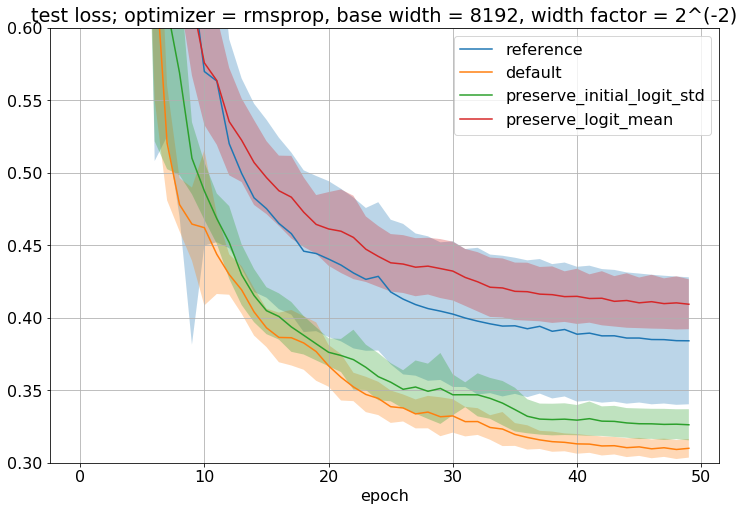

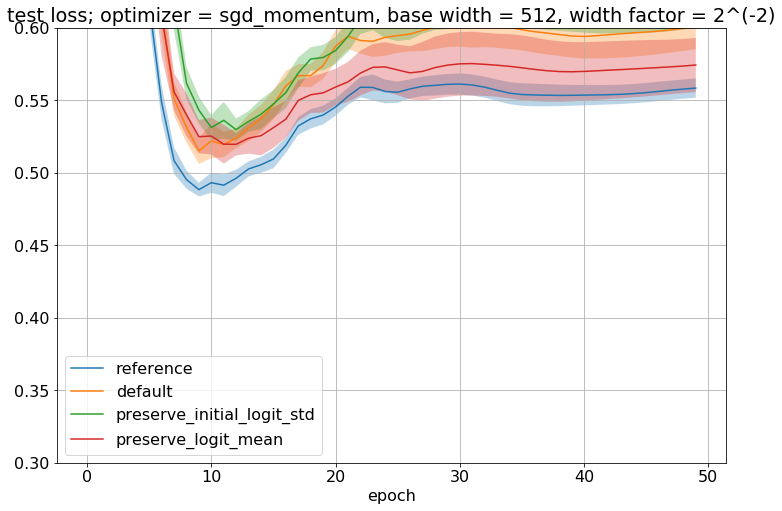

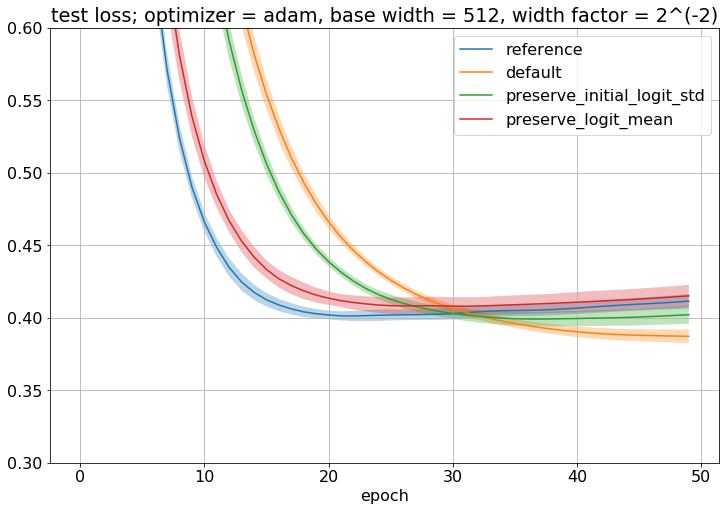

In [320]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data = [[
                    test_losses[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed][epoch]
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)
                plt.fill_between(
                    np.arange(num_epochs),
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

                for scaling_mode in scaling_modes:
                    data = [[
                        test_losses[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(data_mean)
                    plt.fill_between(
                        np.arange(num_epochs),
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [[
                            test_losses[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ] for seed in range(num_seeds)]
                        data = np.array(data)
                        data_mean = data.mean(axis=0)
                        data_std = data.std(axis=0)
                        plt.plot(data_mean)
                        plt.fill_between(
                            np.arange(num_epochs),
                            data_mean - data_std, data_mean + data_std,
                            alpha=0.3
                        )

                plt.title('test loss; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0.3,0.6))
                plt.xlabel('epoch')
                plt.grid(True)
                plt.show()

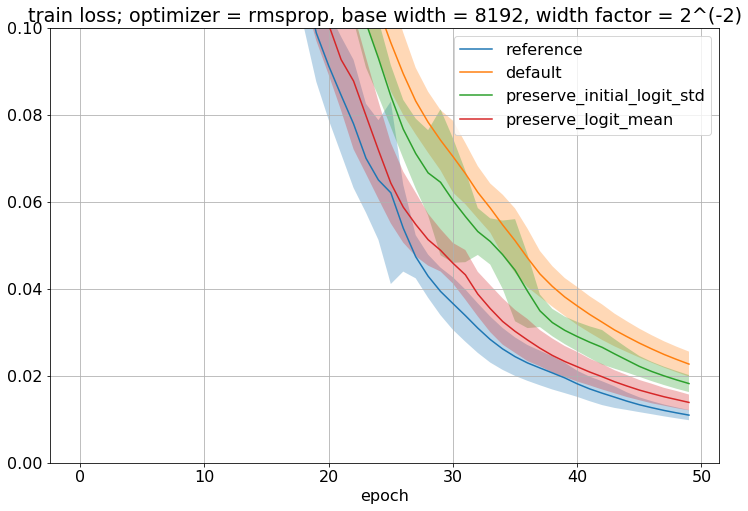

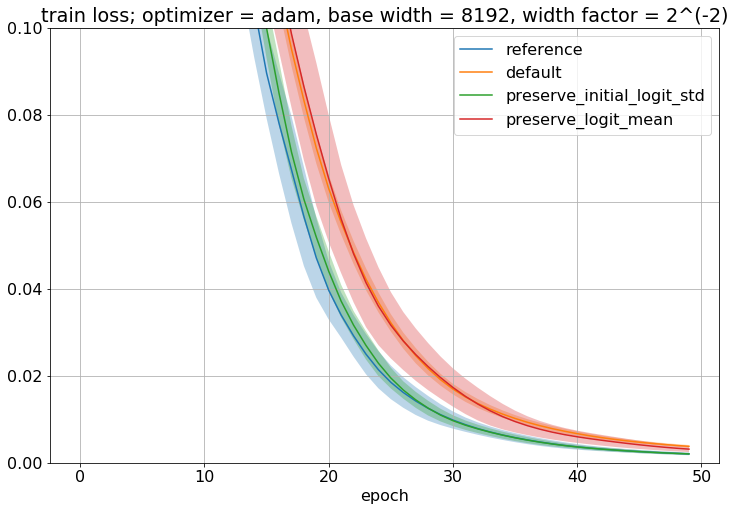

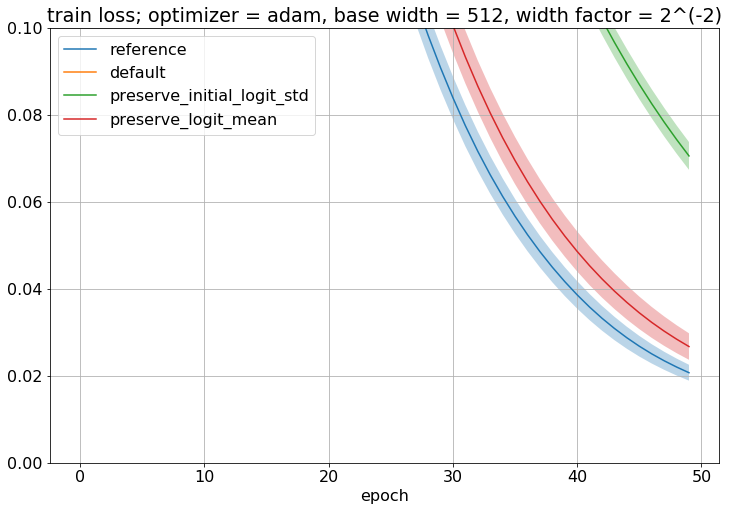

In [321]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data = [[
                    train_losses[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed][epoch]
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)
                plt.fill_between(
                    np.arange(num_epochs),
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

                for scaling_mode in scaling_modes:
                    data = [[
                        train_losses[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(data_mean)
                    plt.fill_between(
                        np.arange(num_epochs),
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [[
                            train_losses[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ] for seed in range(num_seeds)]
                        data = np.array(data)
                        data_mean = data.mean(axis=0)
                        data_std = data.std(axis=0)
                        plt.plot(data_mean)
                        plt.fill_between(
                            np.arange(num_epochs),
                            data_mean - data_std, data_mean + data_std,
                            alpha=0.3
                        )

                plt.title('train loss; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0.,0.5 if optimization_mode == 'sgd' else 0.1))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

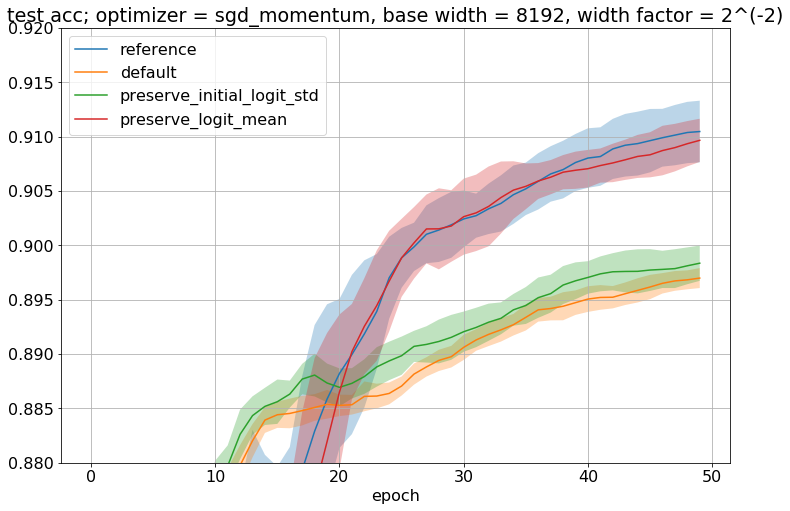

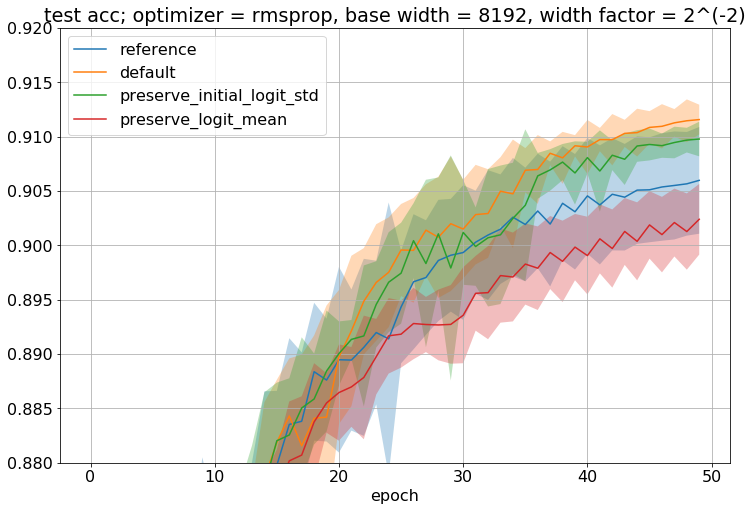

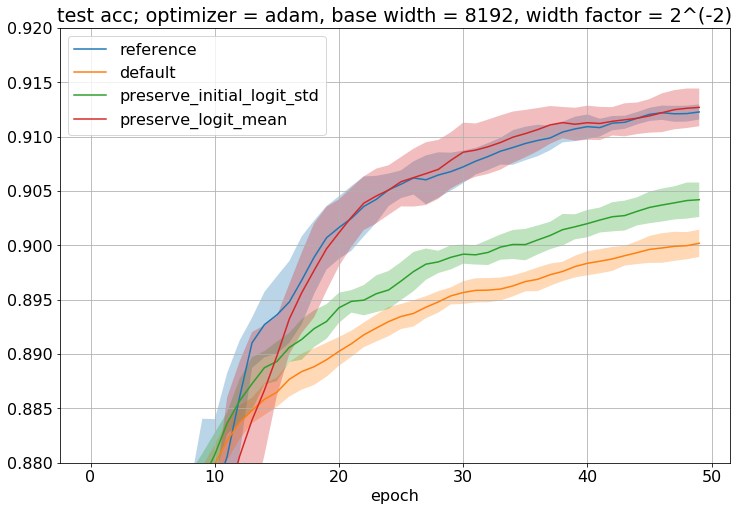

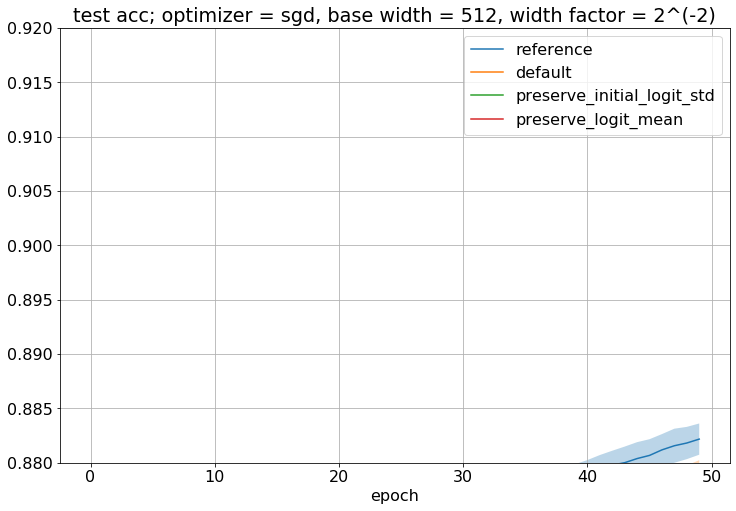

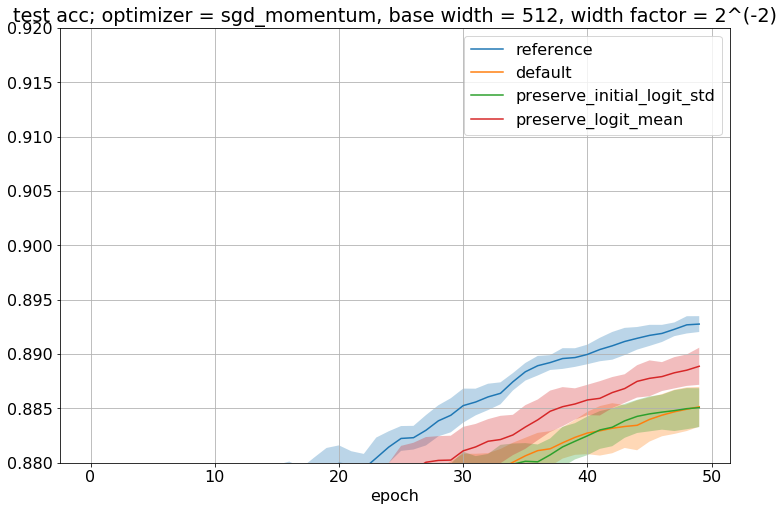

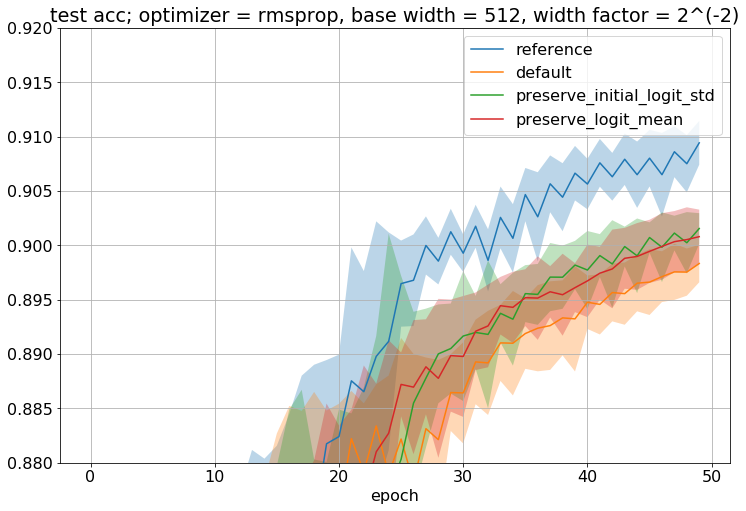

In [322]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data = [[
                    test_accs[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed][epoch]
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)
                plt.fill_between(
                    np.arange(num_epochs),
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

                for scaling_mode in scaling_modes:
                    data = [[
                        test_accs[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(data_mean)
                    plt.fill_between(
                        np.arange(num_epochs),
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [[
                            test_accs[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ] for seed in range(num_seeds)]
                        data = np.array(data)
                        data_mean = data.mean(axis=0)
                        data_std = data.std(axis=0)
                        plt.plot(data_mean)
                        plt.fill_between(
                            np.arange(num_epochs),
                            data_mean - data_std, data_mean + data_std,
                            alpha=0.3
                        )

                plt.title('test acc; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0.88,0.92))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

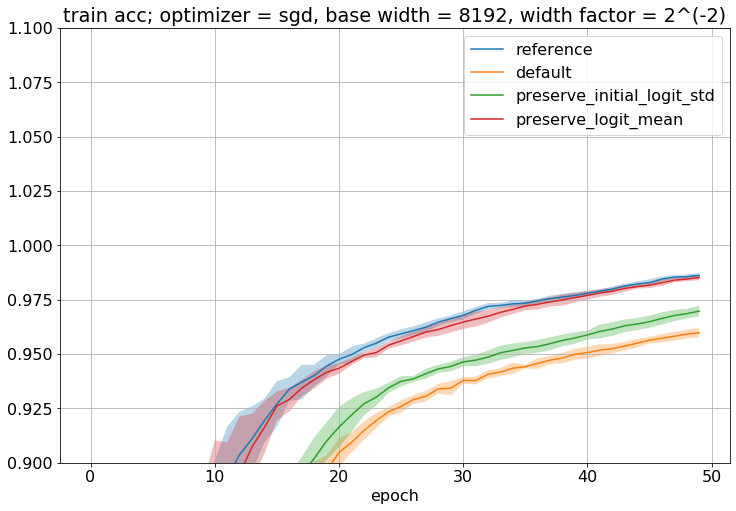

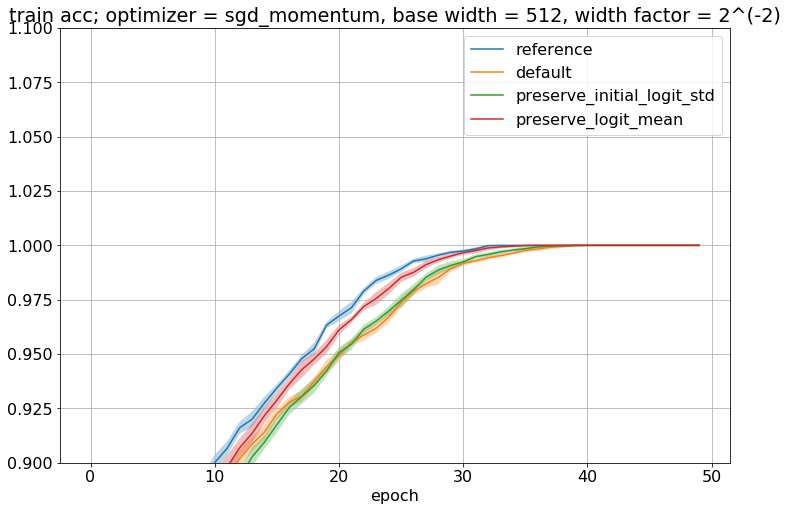

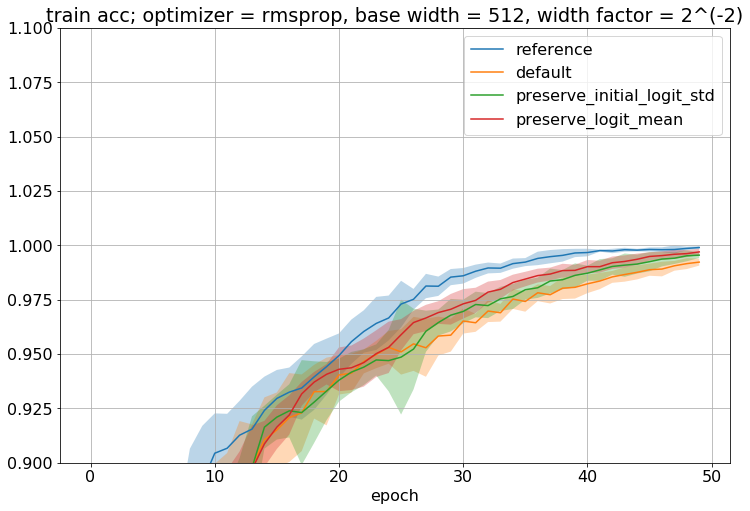

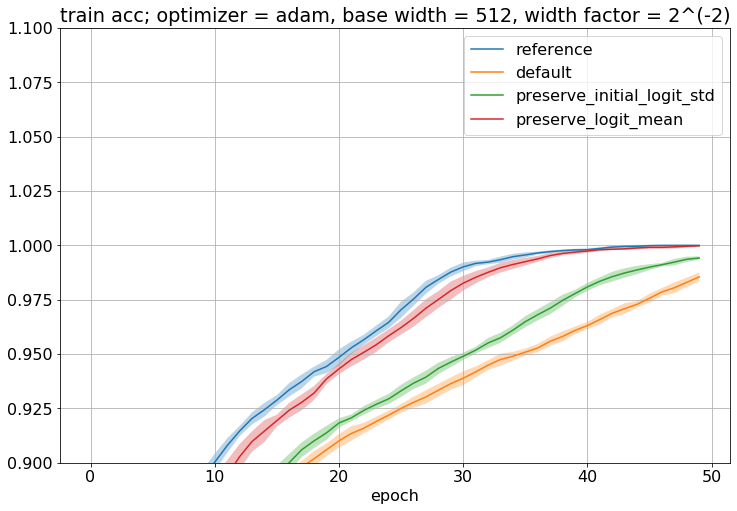

In [323]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data = [[
                    train_accs[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed][epoch]
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(data_mean)
                plt.fill_between(
                    np.arange(num_epochs),
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

                for scaling_mode in scaling_modes:
                    data = [[
                        train_accs[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(data_mean)
                    plt.fill_between(
                        np.arange(num_epochs),
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [[
                            train_accs[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ] for seed in range(num_seeds)]
                        data = np.array(data)
                        data_mean = data.mean(axis=0)
                        data_std = data.std(axis=0)
                        plt.plot(data_mean)
                        plt.fill_between(
                            np.arange(num_epochs),
                            data_mean - data_std, data_mean + data_std,
                            alpha=0.3
                        )

                plt.title('train acc; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0.9,1.1))
                plt.grid(True)
                plt.xlabel('epoch')
                plt.show()

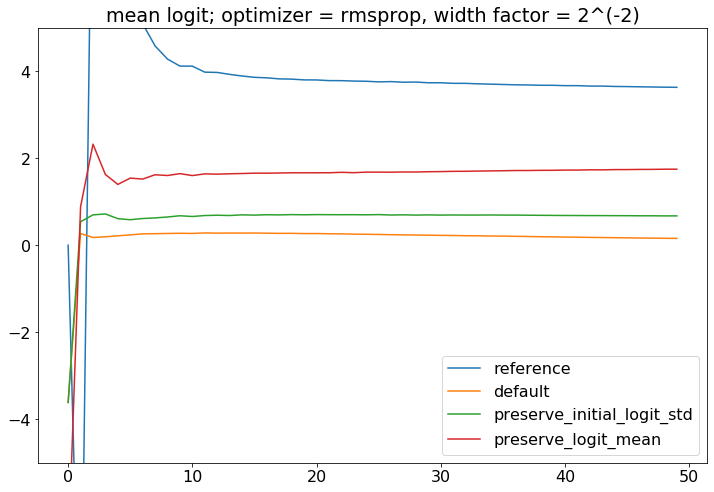

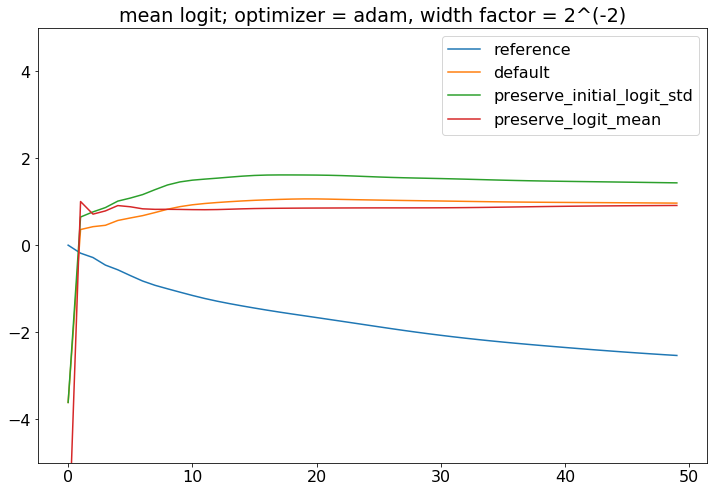

In [289]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data_ref = [
                    class_mean_data_mean_mean_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_ref = np.array(data_ref)
                plt.plot(data_ref)

                for scaling_mode in scaling_modes:
                    data = [
                        class_mean_data_mean_mean_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data = np.array(data)
                    plt.plot(data / data_ref)

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [
                            class_mean_data_mean_mean_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data = np.array(data)
                        plt.plot(data)

                plt.title('mean logit; optimizer = {}, width factor = 2^({})'.format(optimization_mode, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((-5,5))
                plt.show()

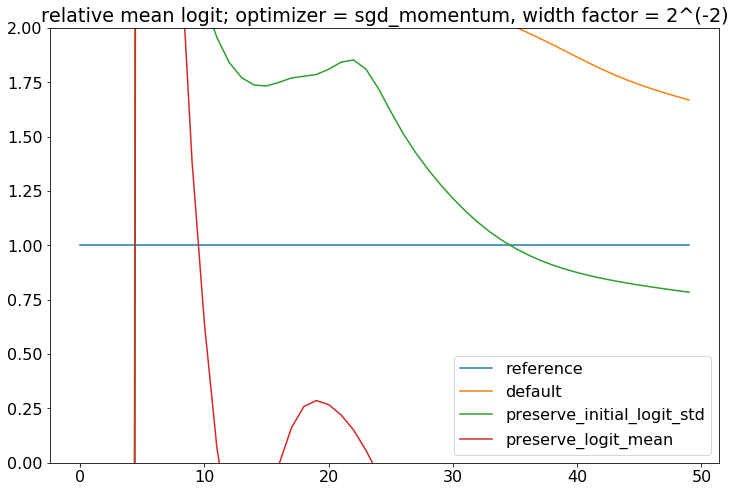

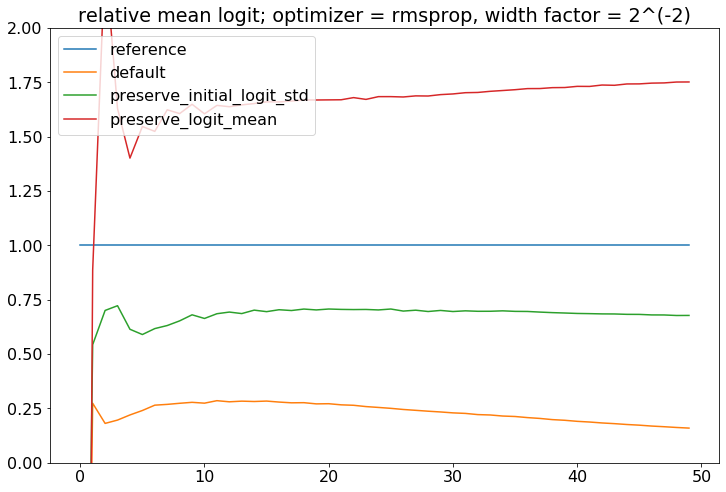

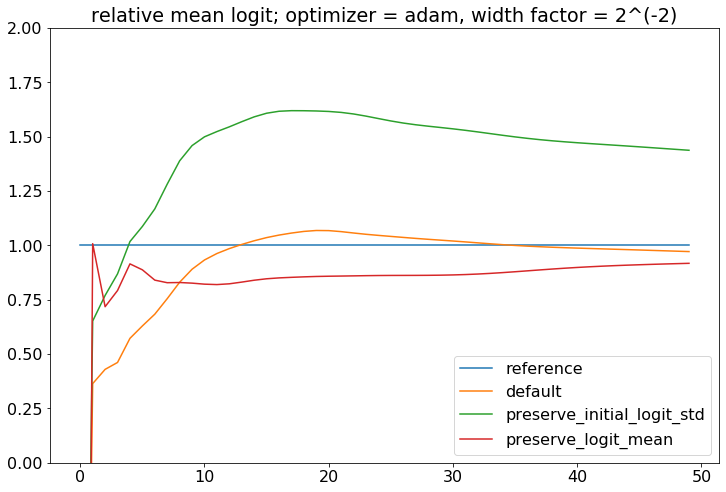

In [290]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data_ref = [
                    class_mean_data_mean_mean_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_ref = np.array(data_ref)
                plt.plot(data_ref / data_ref)

                for scaling_mode in scaling_modes:
                    data = [
                        class_mean_data_mean_mean_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data = np.array(data)
                    plt.plot(data / data_ref)

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [
                            class_mean_data_mean_mean_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data = np.array(data)
                        plt.plot(data / data_ref)

                plt.title('relative mean logit; optimizer = {}, width factor = 2^({})'.format(optimization_mode, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0,2))
                plt.show()

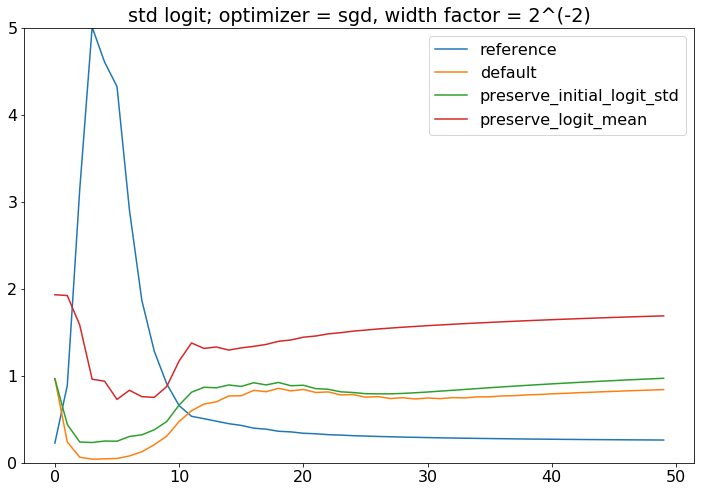

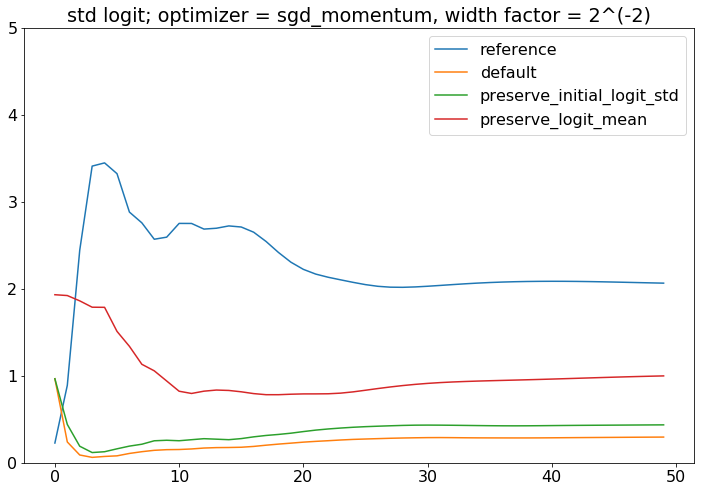

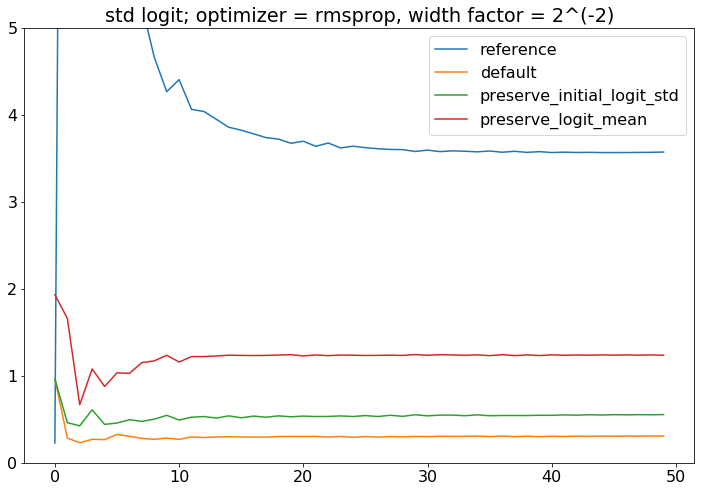

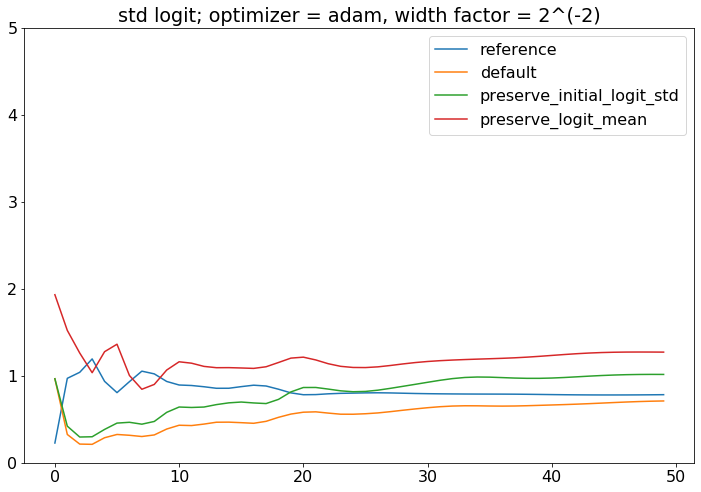

In [291]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data_ref = [
                    class_mean_data_mean_std_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_ref = np.array(data_ref)
                plt.plot(data_ref)

                for scaling_mode in scaling_modes:
                    data = [
                        class_mean_data_mean_std_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data = np.array(data)
                    plt.plot(data / data_ref)

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [
                            class_mean_data_mean_std_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data = np.array(data)
                        plt.plot(data)

                plt.title('std logit; optimizer = {}, width factor = 2^({})'.format(optimization_mode, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0,5))
                plt.show()

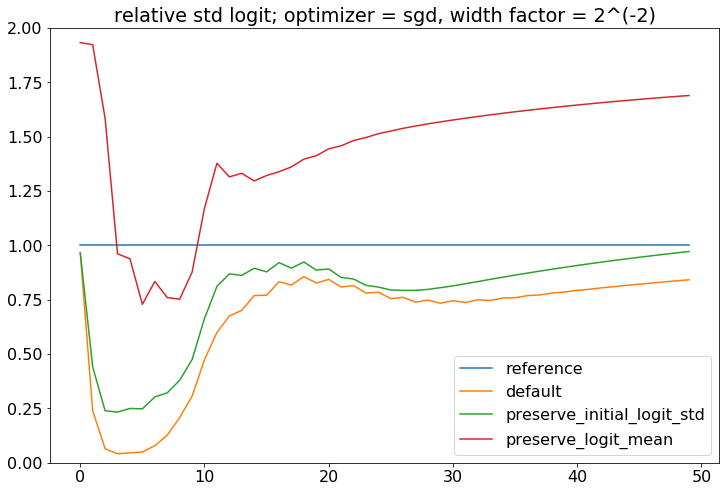

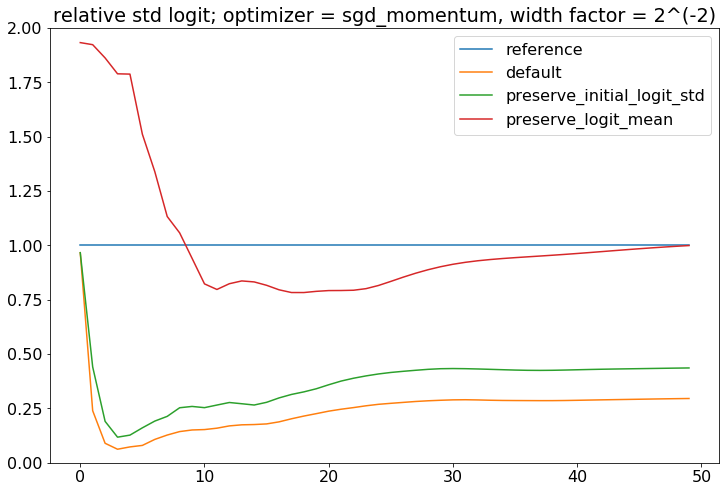

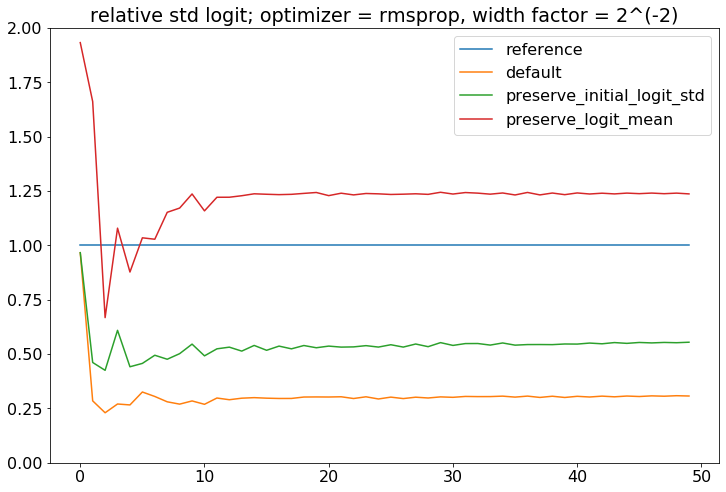

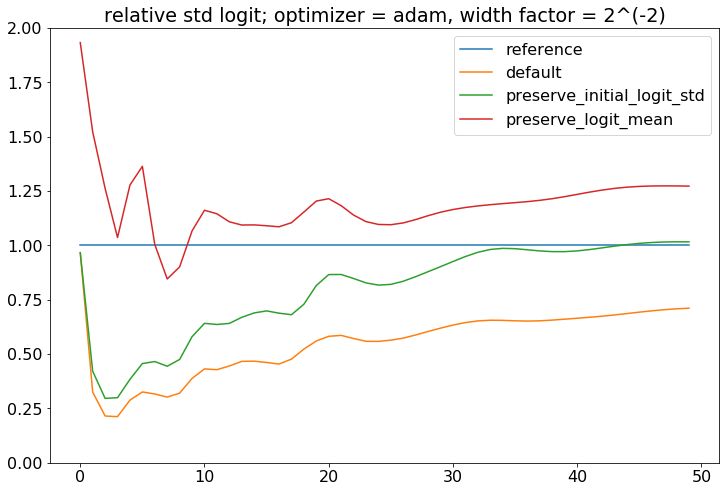

In [292]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data_ref = [
                    class_mean_data_mean_std_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_ref = np.array(data_ref)
                plt.plot(data_ref / data_ref)

                for scaling_mode in scaling_modes:
                    data = [
                        class_mean_data_mean_std_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data = np.array(data)
                    plt.plot(data / data_ref)

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data = [
                            class_mean_data_mean_std_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data = np.array(data)
                        plt.plot(data / data_ref)

                plt.title('relative std logit; optimizer = {}, width factor = 2^({})'.format(optimization_mode, log_width_factor))
                plt.legend(legend_list)
                plt.ylim((0,2))
                plt.show()

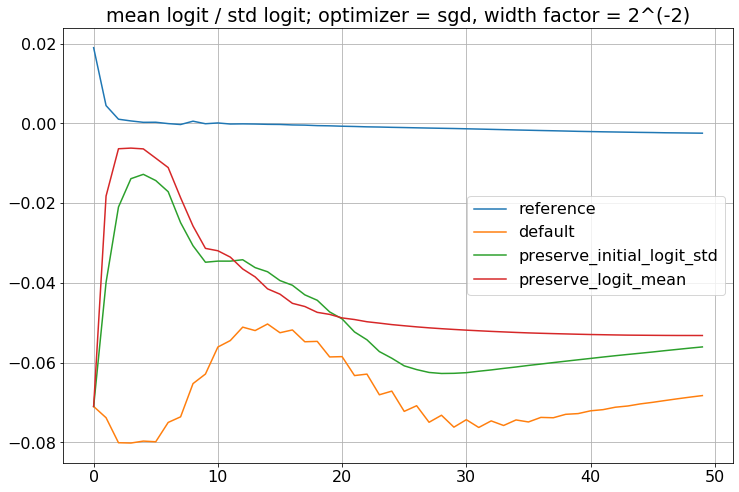

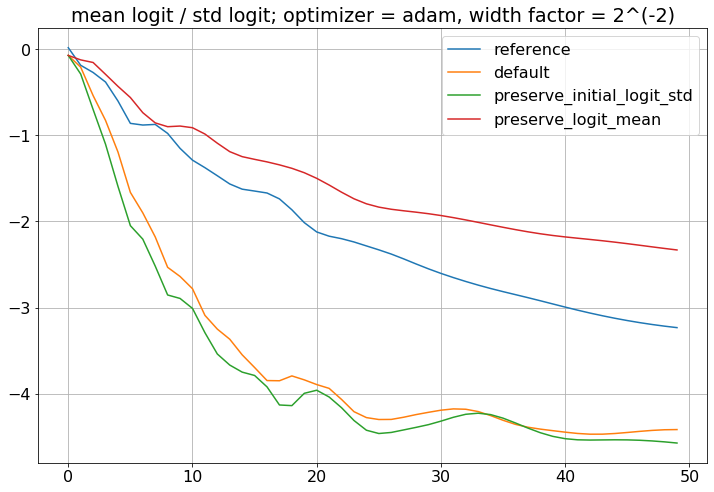

In [294]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_lr_factor in log_lr_factors:
            _ = plt.figure(figsize=(12,8))
            for log_width_factor in log_width_factors[:-1]:

                data_std_ref = [
                    class_mean_data_mean_std_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_std_ref = np.array(data_std_ref)
                data_mean_ref = [
                    class_mean_data_mean_mean_logit[base_width][optimization_mode]['none']['default'][0][log_lr_factor][epoch] 
                    for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                ]
                data_mean_ref = np.array(data_mean_ref)
                plt.plot(data_mean_ref / data_std_ref)

                for scaling_mode in scaling_modes:
                    data_std = [
                        class_mean_data_mean_std_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data_std = np.array(data_std)
                    data_mean = [
                        class_mean_data_mean_mean_logit[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][epoch] 
                        for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                    ]
                    data_mean = np.array(data_mean)
                    plt.plot(data_mean / data_std)

                if show_adapted_results:
                    for adaptivity_mode in adaptivity_modes[1:]:
                        data_std = [
                            class_mean_data_mean_std_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data_std = np.array(data_std)
                        data_mean = [
                            class_mean_data_mean_mean_logit[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][epoch] 
                            for epoch in range(num_epochs) if (epoch+1) % eval_every == 0
                        ]
                        data_mean = np.array(data_mean)
                        plt.plot(data_mean / data_std)

                plt.title('mean logit / std logit; optimizer = {}, width factor = 2^({})'.format(optimization_mode, log_width_factor))
                plt.legend(legend_list)
                #plt.ylim((0,5))
                plt.grid(True)
                plt.show()

In [151]:
#defaultdict_constructor = NestedDefaultDictConstructor(float, 7)
defaultdict_constructor = lambda: defaultdict(lambda: defaultdict(
    lambda: defaultdict(lambda: defaultdict(
        lambda: defaultdict(lambda: defaultdict(
            lambda: defaultdict(float)))))))

final_train_losses = defaultdict_constructor()
final_test_losses = defaultdict_constructor()

final_train_accs = defaultdict_constructor()
final_test_accs = defaultdict_constructor()

In [324]:
num_epochs = 50
num_seeds = 10

num_hidden = 1
bias = False

base_widths = [8192, 512]
optimization_modes = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']
adaptivity_modes = ['none', 'adapt_mean', 'adapt_std', 'adapt_mean_std_av']
scaling_modes = ['default', 'preserve_initial_logit_std', 'preserve_logit_mean']
log_width_factors = [-4, -2, 0]
log_lr_factors = [-3, -2, -1, 0, 1, 2, 3]

In [ ]:
for base_width in base_widths[-1:]:
    for optimization_mode in optimization_modes[2:]:
        for adaptivity_mode in adaptivity_modes[:1]:
            for scaling_mode in scaling_modes:
                if adaptivity_mode != 'none' and scaling_mode != 'preserve_initial_logit_std':
                    continue
                for log_width_factor in log_width_factors[::-1]:
                    if scaling_mode != 'default' and log_width_factor == 0:
                        continue
                    for log_lr_factor in log_lr_factors:
                        print('base width = {}'.format(base_width))
                        print('optimization mode = {}'.format(optimization_mode))
                        print('adaptivity mode = {}'.format(adaptivity_mode))
                        print('scaling mode: {}'.format(scaling_mode))
                        print('log width factor = {}'.format(log_width_factor))
                        print('log lr factor = {}'.format(log_lr_factor))

                        if optimization_mode == 'sgd':
                            optimizer_class = optim.SGD
                            base_lr = 1e-1
                        elif optimization_mode == 'sgd_momentum':
                            optimizer_class = SGDMomentum
                            base_lr = 1e-1
                        elif optimization_mode == 'rmsprop':
                            optimizer_class = optim.RMSprop
                            base_lr = 1e-3
                        elif optimization_mode == 'adam':
                            optimizer_class = optim.Adam
                            base_lr = 1e-3
                        else:
                            raise ValueError

                        if log_width_factor >= 0:
                            width = base_width * (2 ** log_width_factor)
                        else:
                            width = base_width // (2 ** (-log_width_factor))

                        mod_base_lr = base_lr * (2 ** log_lr_factor)
                        
                        models = []
                        states = []
                        optimizers = []

                        for seed in range(num_seeds):
                            torch.manual_seed(seed)
                            #np.random.seed(seed)

                            model = FCNet(input_shape, num_classes, width=width, num_hidden=num_hidden, bias=bias).to(device)
                            models.append(model)

                            optimizer = optimizer_class(
                                [
                                    {'params': model.input_layer.parameters()},
                                    {'params': model.hidden_layers.parameters()},
                                    {'params': model.output_layer.parameters()}
                                ], lr=mod_base_lr
                            )
                            optimizers.append(optimizer)

                            scale_hyperparams(
                                model.input_layer, model.hidden_layers, model.output_layer, 
                                optimizer=optimizer, width_factor=2**log_width_factor, scaling_mode=scaling_mode
                            )

                            states.append(torch.get_rng_state())

                        for epoch in range(num_epochs):
                            logits = []

                            for model, state, seed in zip(models, states, range(num_seeds)):
                                torch.set_rng_state(state)

                                model.eval()
                                logits.append([])
                                with torch.no_grad():
                                    for X, _ in test_loader_det:
                                        X = X.to(device)
                                        logits[-1].append(model(X))
                                logits[-1] = torch.cat(logits[-1])

                            logits = torch.stack(logits)
                            std_logits, mean_logits = torch.std_mean(logits, dim=0)
                            mean_std_logit, mean_mean_logit = std_logits.mean().item(), mean_logits.mean().item()

                            class_mean_data_mean_mean_logit[
                                base_width
                            ][optimization_mode][adaptivity_mode][scaling_mode][
                                log_width_factor
                            ][log_lr_factor][epoch] = mean_mean_logit
                            class_mean_data_mean_std_logit[
                                base_width
                            ][optimization_mode][adaptivity_mode][scaling_mode][
                                log_width_factor
                            ][log_lr_factor][epoch] = mean_std_logit

                            mean_mean_logit_ref = class_mean_data_mean_mean_logit[
                                base_width
                            ][optimization_mode]['none']['default'][0][log_lr_factor][epoch]
                            mean_std_logit_ref = class_mean_data_mean_std_logit[
                                base_width
                            ][optimization_mode]['none']['default'][0][log_lr_factor][epoch]

                            correction_factor_from_mean_logits = mean_mean_logit_ref / mean_mean_logit
                            correction_factor_from_std_logits = mean_std_logit_ref / mean_std_logit

                            #print('epoch {}'.format(epoch+1))
                            #print('correction factor from mean logits = {:.2f}'.format(correction_factor_from_mean_logits))
                            #print('correction factor from std logits = {:.2f}'.format(correction_factor_from_std_logits))
                            #print()

                            if epoch > 0:
                                #correction_factor_from_mean_logits = np.clip(correction_factor_from_mean_logits, 0.4, 2.5)
                                if adaptivity_mode == 'none':
                                    correction_factor = 1
                                elif adaptivity_mode == 'adapt_mean':
                                    correction_factor = correction_factor_from_mean_logits
                                elif adaptivity_mode == 'adapt_std':
                                    correction_factor = correction_factor_from_std_logits
                                elif adaptivity_mode == 'adapt_mean_std_av':
                                    correction_factor = math.sqrt(
                                        correction_factor_from_std_logits / abs(correction_factor_from_mean_logits)
                                    ) * correction_factor_from_mean_logits
                                else:
                                    raise ValueError

                                for model, optimizer in zip(models, optimizers):
                                    for layer in chain(model.hidden_layers, [model.output_layer]):
                                        if hasattr(layer, 'weight'):
                                            layer.weight.data = layer.weight.data * correction_factor
                                        if hasattr(layer, 'bias'):
                                            if layer.bias is not None:
                                                raise NotImplementedError
                                    if optimization_mode in ['sgd', 'sgd_momentum']:
                                        for param_group in optimizer.param_groups[:1]:
                                            param_group['lr'] /= abs(correction_factor)
                                    for param_group in optimizer.param_groups[1:]:
                                        param_group['lr'] *= abs(correction_factor)

                            for model, state, seed, optimizer in zip(models, states, range(num_seeds), optimizers):
                                torch.set_rng_state(state)

                                model.train()
                                train_loss, train_acc = perform_epoch(model, train_loader, optimizer=optimizer, device=device)

                                if epoch == num_epochs - 1:
                                    final_train_losses[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed] = train_loss
                                    final_train_accs[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed] = train_acc

                                    model.eval()
                                    test_loss, test_acc = perform_epoch(model, test_loader, device=device)
                                    final_test_losses[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed] = test_loss
                                    final_test_accs[
                                        base_width
                                    ][optimization_mode][adaptivity_mode][scaling_mode][
                                        log_width_factor
                                    ][log_lr_factor][seed] = test_acc

                                    print('seed = {}'.format(seed))
                                    print('train loss = {:.4f}, train acc = {:.2f}'.format(train_loss, train_acc*100))
                                    print('test loss = {:.4f}, test acc = {:.2f}'.format(test_loss, test_acc*100))            
                                    print()

                                state = torch.get_rng_state()


In [210]:
import pickle

results_dir = 'results/final/'

with open(results_dir+'final_train_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_losses), f)
with open(results_dir+'final_test_losses.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_losses), f)
with open(results_dir+'final_train_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_train_accs), f)
with open(results_dir+'final_test_accs.pkl', 'wb') as f:
    pickle.dump(defaultdict_to_dict(final_test_accs), f)
    

In [220]:
plt.rcParams.update({'font.size': 16})

In [333]:
show_adapted_results = False

In [334]:
legend_list = ['reference'] + scaling_modes
if show_adapted_results:
    legend_list = legend_list + adaptivity_modes[1:]

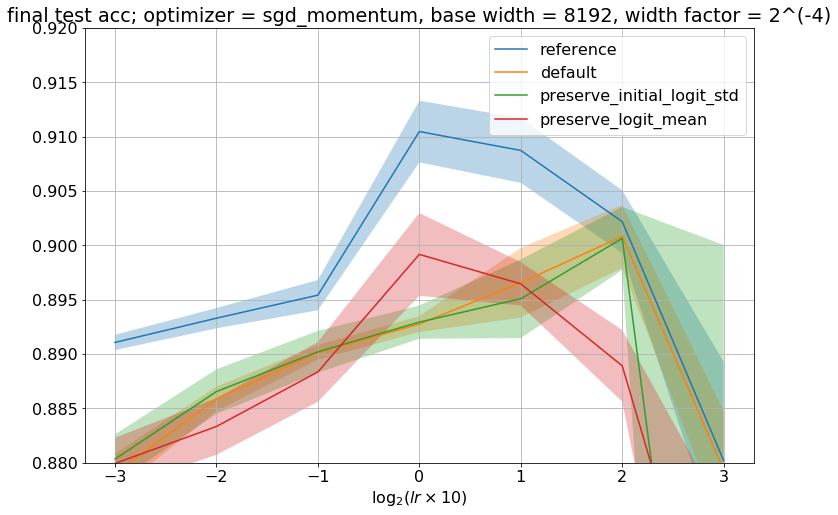

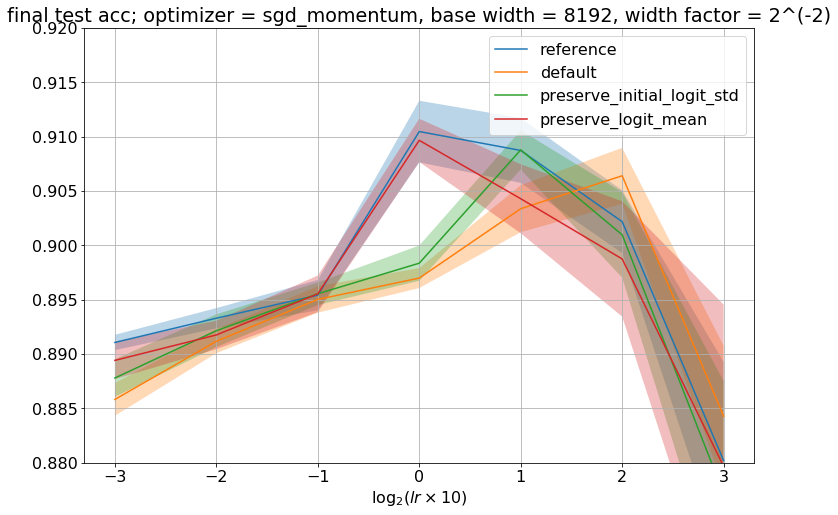

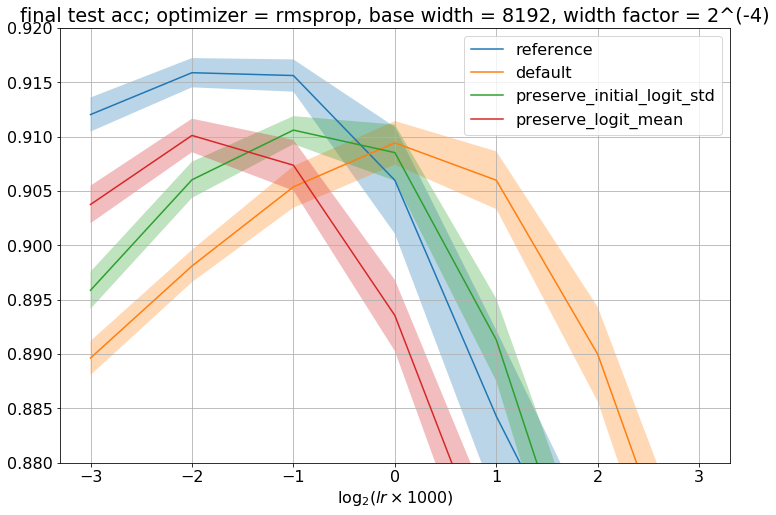

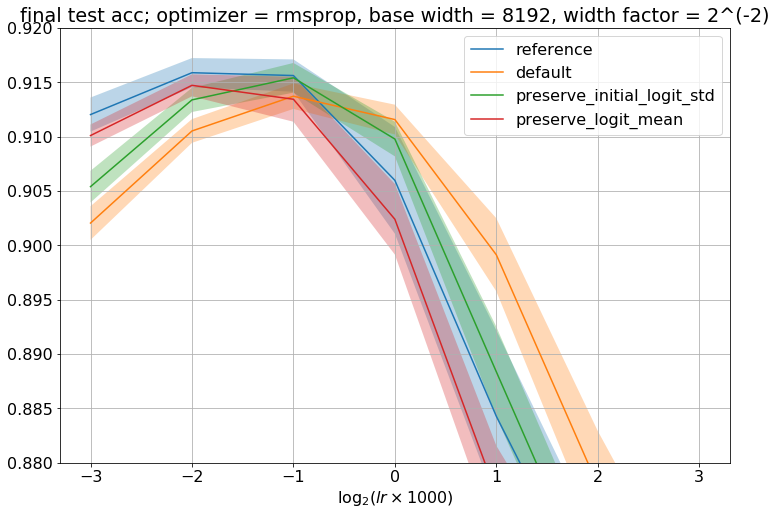

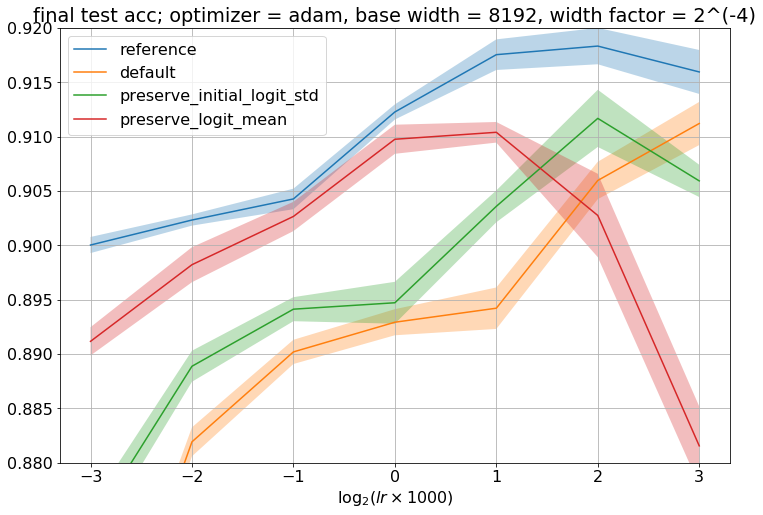

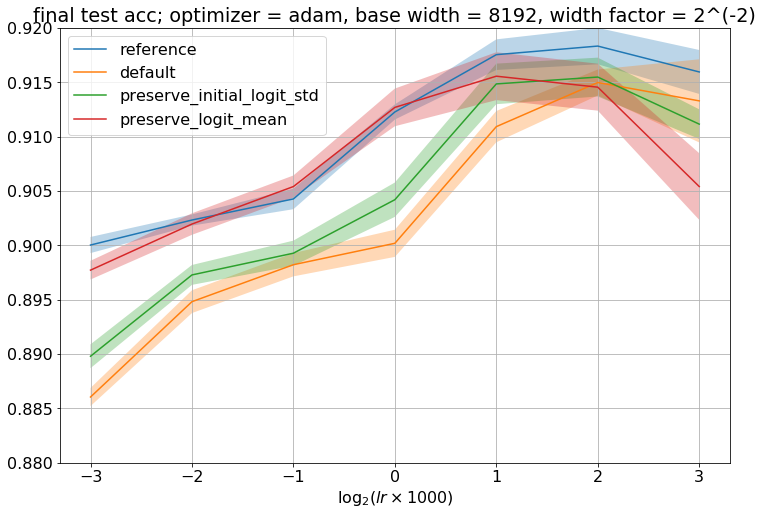

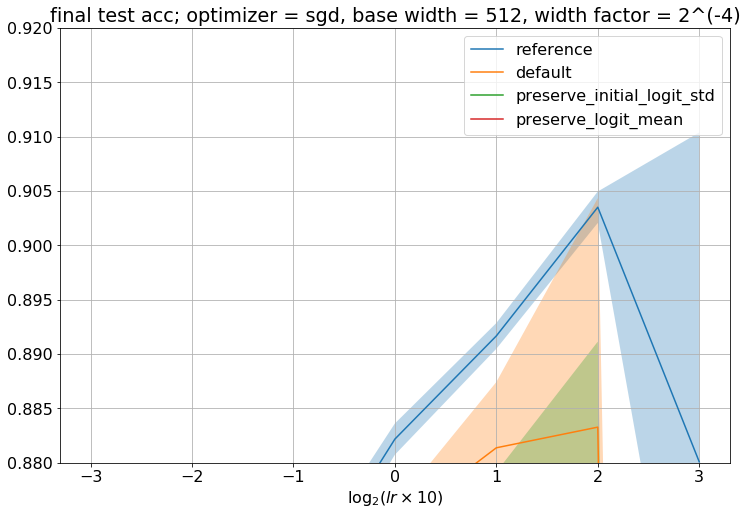

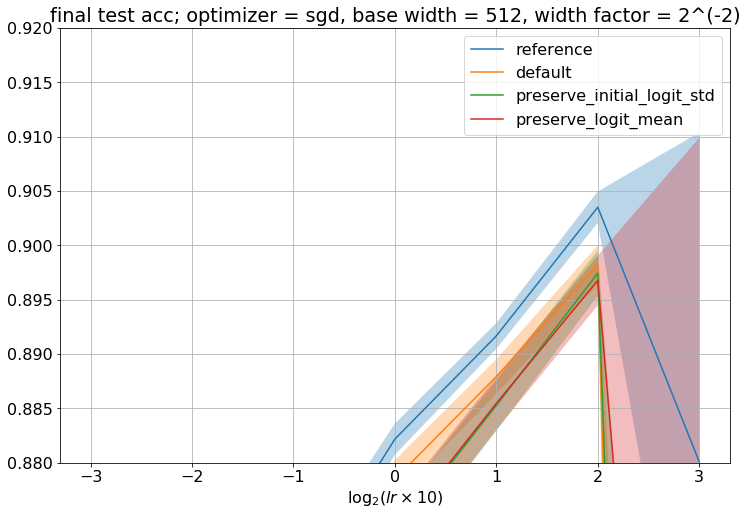

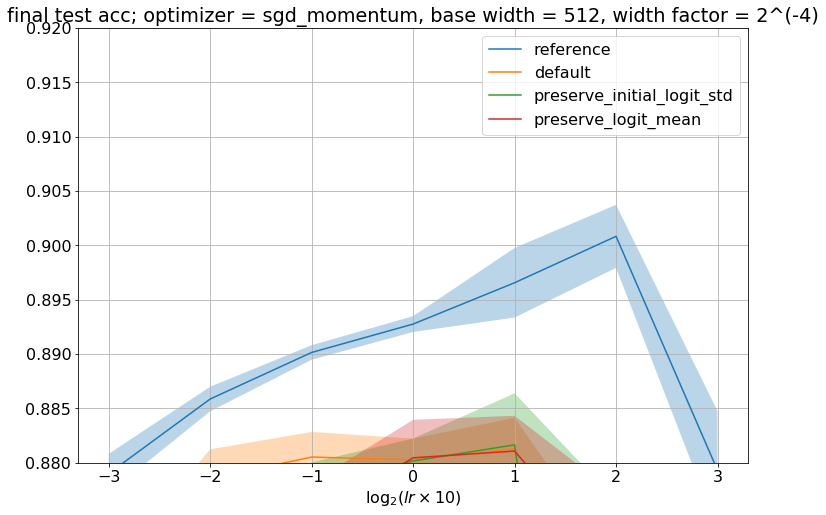

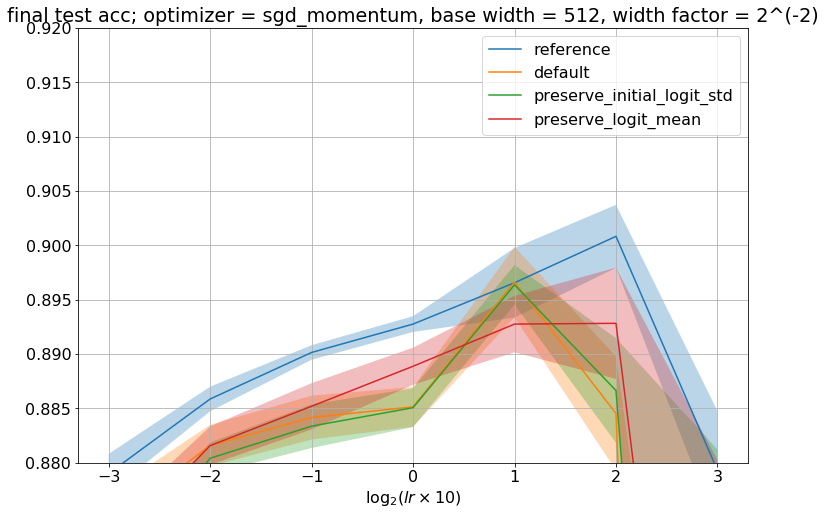

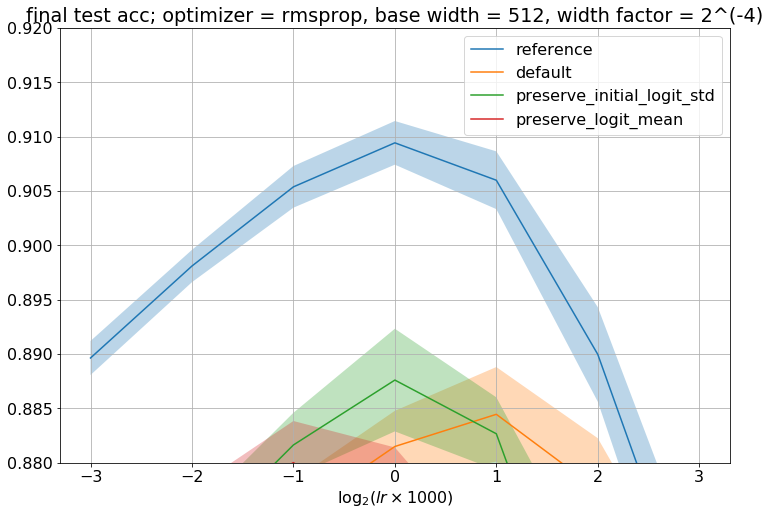

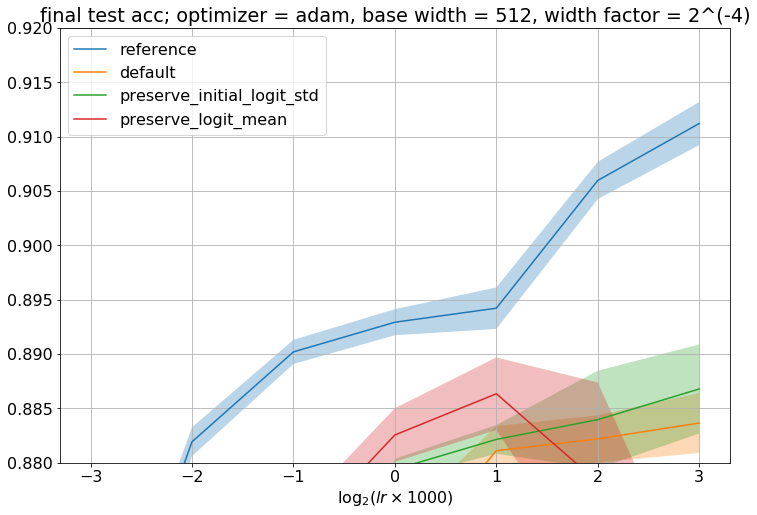

In [336]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            data = [[
                final_test_accs[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed]
                for log_lr_factor in log_lr_factors
            ] for seed in range(num_seeds)]
            data = np.array(data)
            #print(data)
            data_mean = data.mean(axis=0)
            data_std = data.std(axis=0)
            plt.plot(log_lr_factors, data_mean)
            plt.fill_between(
                log_lr_factors,
                data_mean - data_std, data_mean + data_std,
                alpha=0.3
            )

            for scaling_mode in scaling_modes:
                data = [[
                    final_test_accs[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(log_lr_factors, data_mean)
                plt.fill_between(
                    log_lr_factors,
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

            if show_adapted_results:
                for adaptivity_mode in adaptivity_modes[1:]:
                    data = [[
                        final_test_accs[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(log_lr_factors, data_mean)
                    plt.fill_between(
                        log_lr_factors,
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

            plt.title('final test acc; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
            plt.legend(legend_list)
            #if base_width == 8192:
            plt.ylim((0.88,0.92))
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = 1e-1
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = 1e-3
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

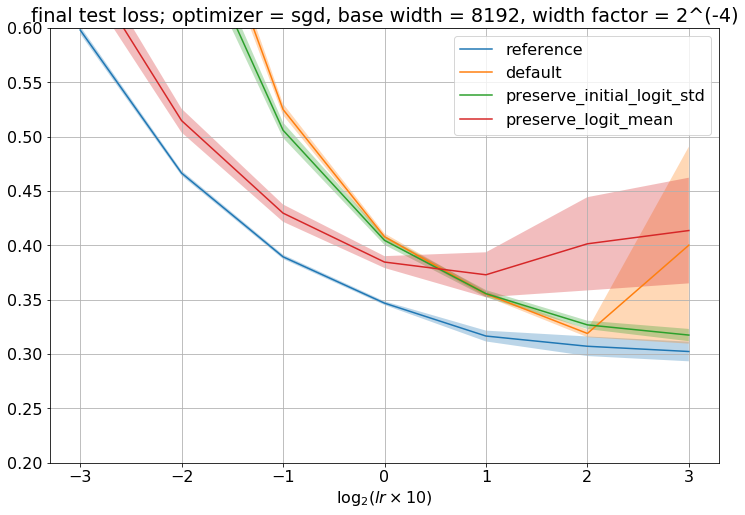

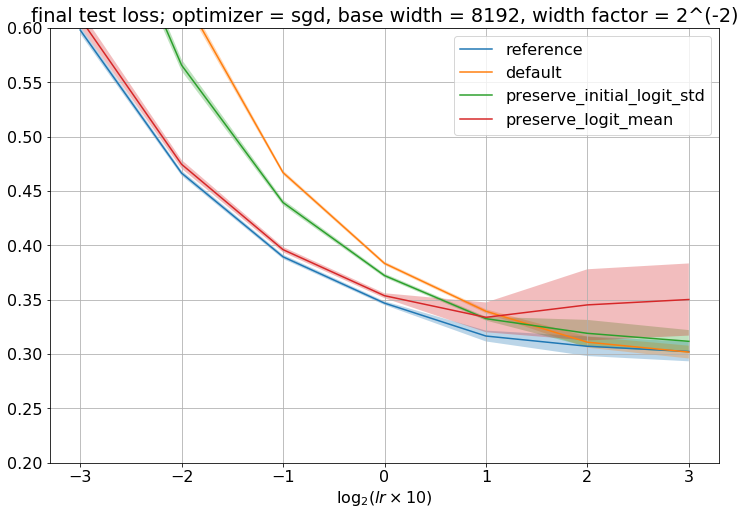

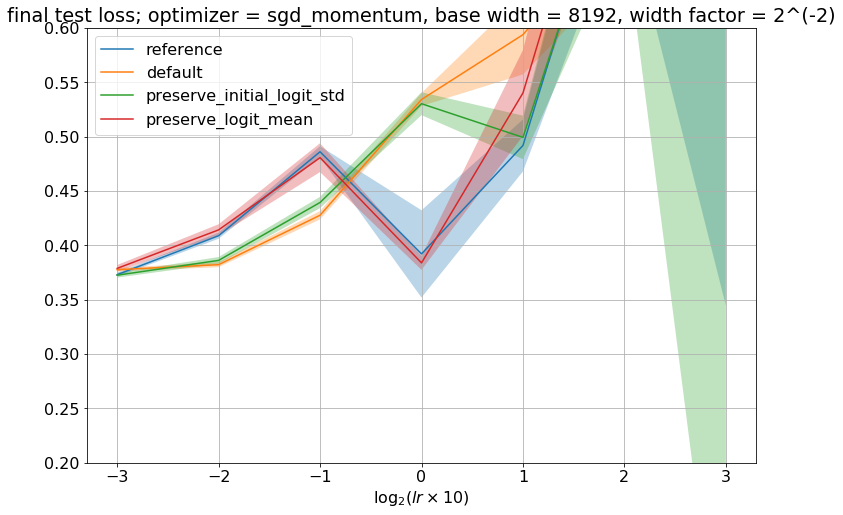

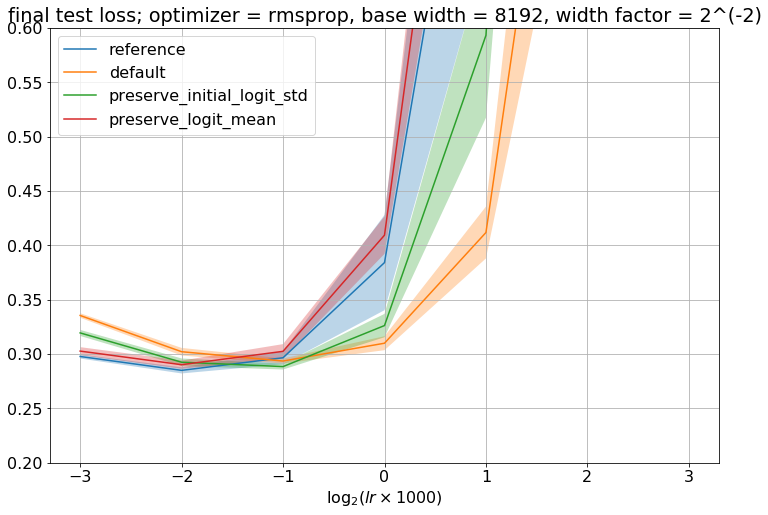

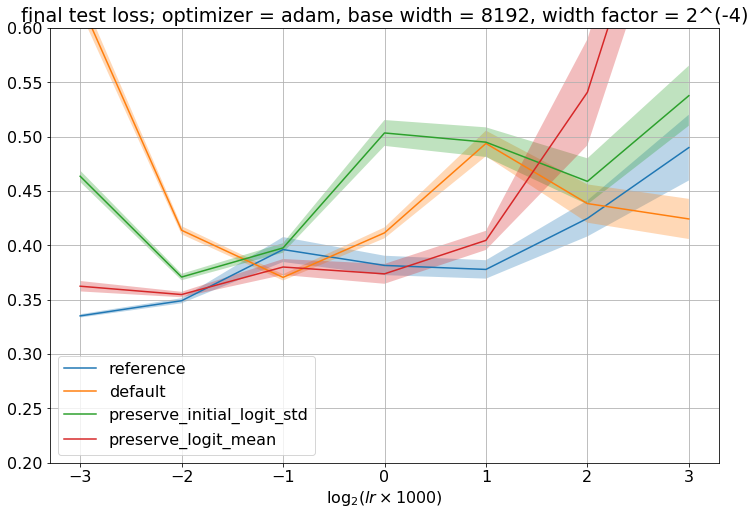

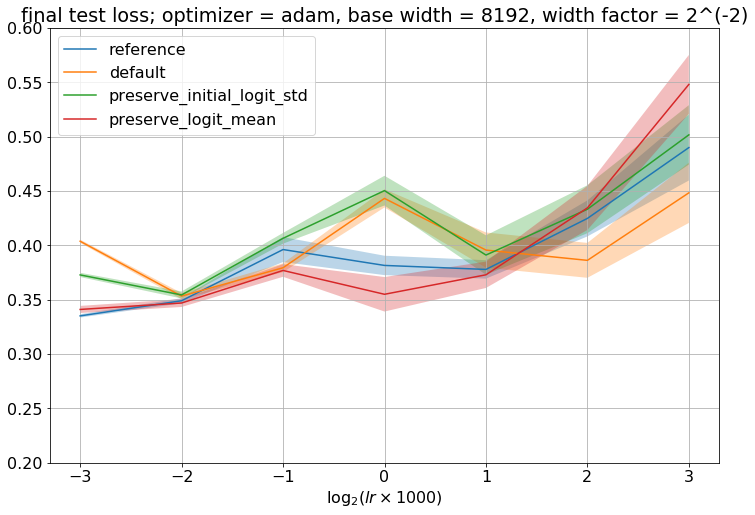

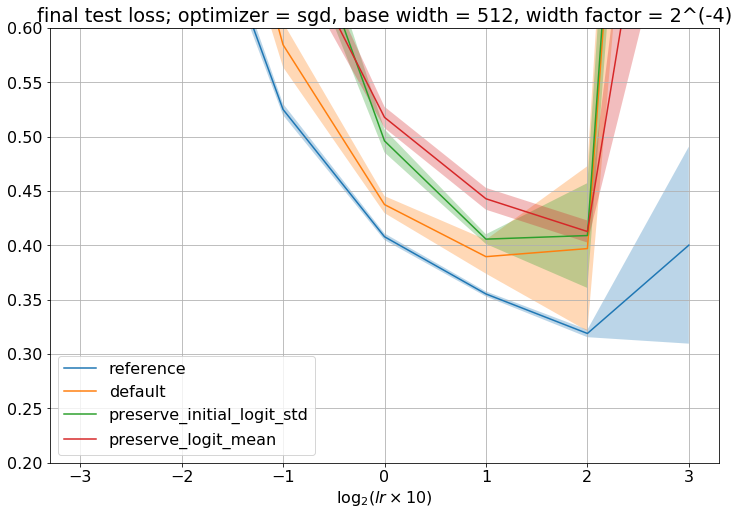

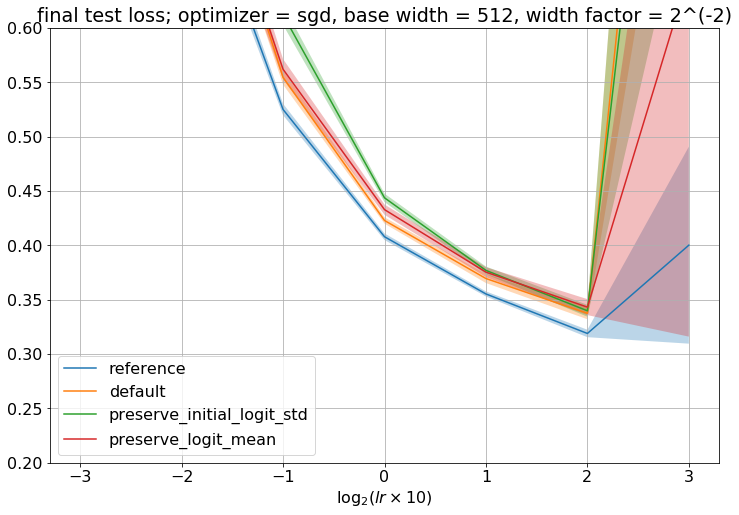

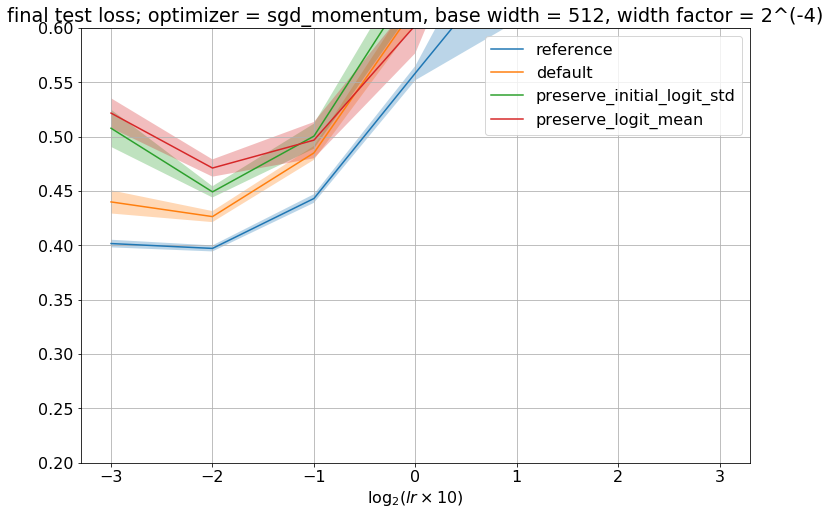

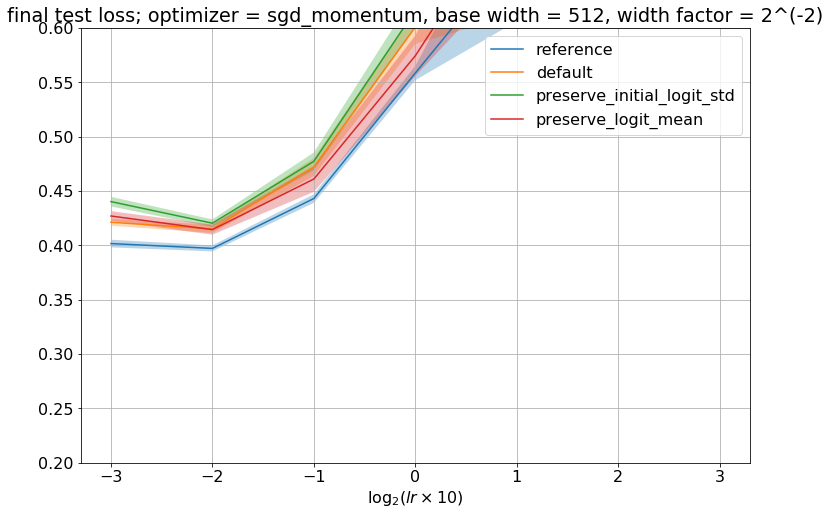

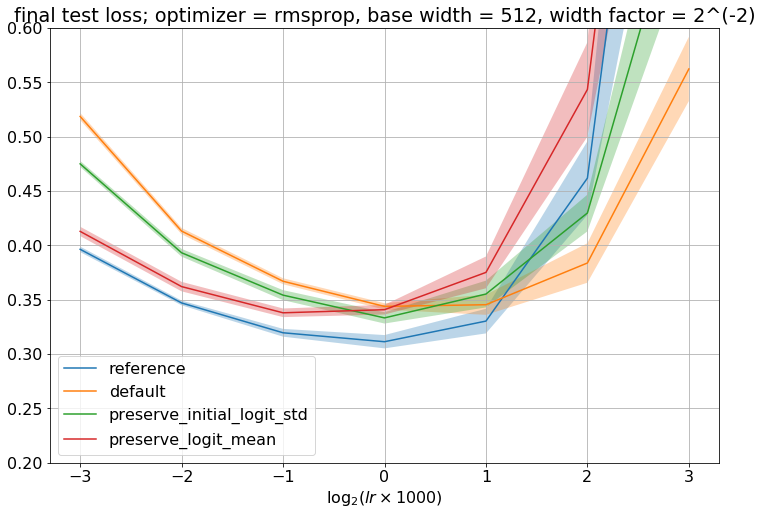

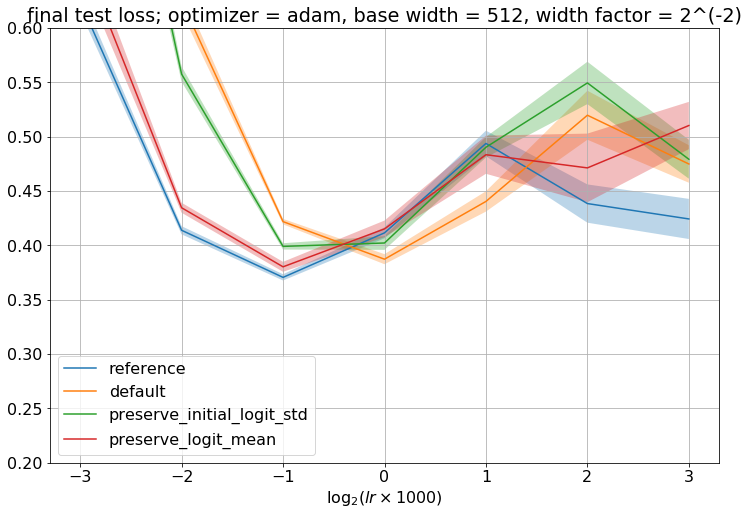

In [337]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            data = [[
                final_test_losses[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed]
                for log_lr_factor in log_lr_factors
            ] for seed in range(num_seeds)]
            data = np.array(data)
            data_mean = data.mean(axis=0)
            data_std = data.std(axis=0)
            plt.plot(log_lr_factors, data_mean)
            plt.fill_between(
                log_lr_factors,
                data_mean - data_std, data_mean + data_std,
                alpha=0.3
            )

            for scaling_mode in scaling_modes:
                data = [[
                    final_test_losses[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(log_lr_factors, data_mean)
                plt.fill_between(
                    log_lr_factors,
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

            if show_adapted_results:
                for adaptivity_mode in adaptivity_modes[1:]:
                    data = [[
                        final_test_losses[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(log_lr_factors, data_mean)
                    plt.fill_between(
                        log_lr_factors,
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

            plt.title('final test loss; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
            plt.legend(legend_list)
            plt.ylim((0.2,0.6))
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = 1e-1
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = 1e-3
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

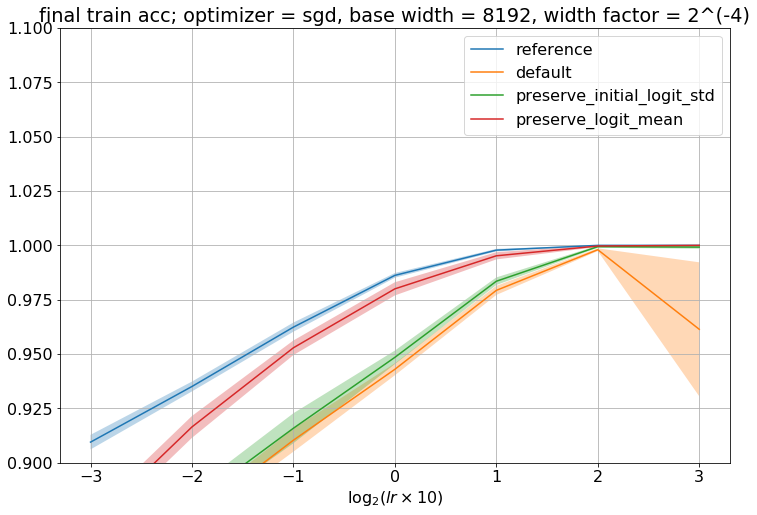

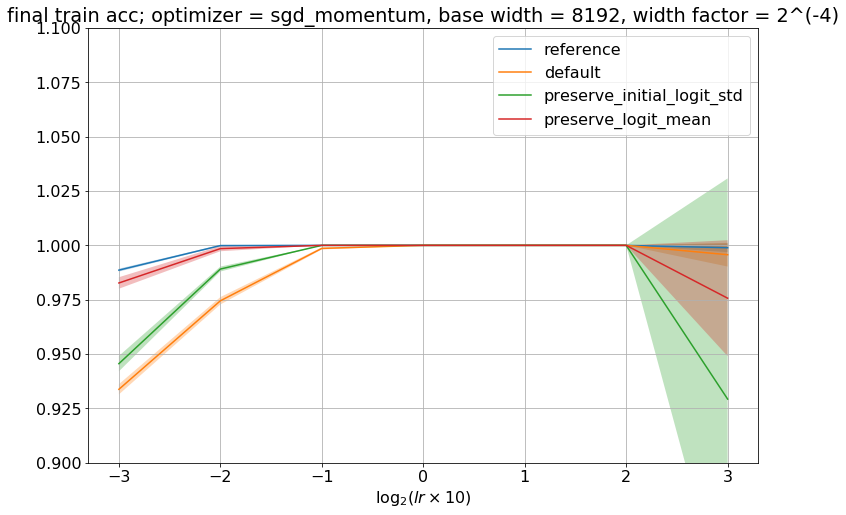

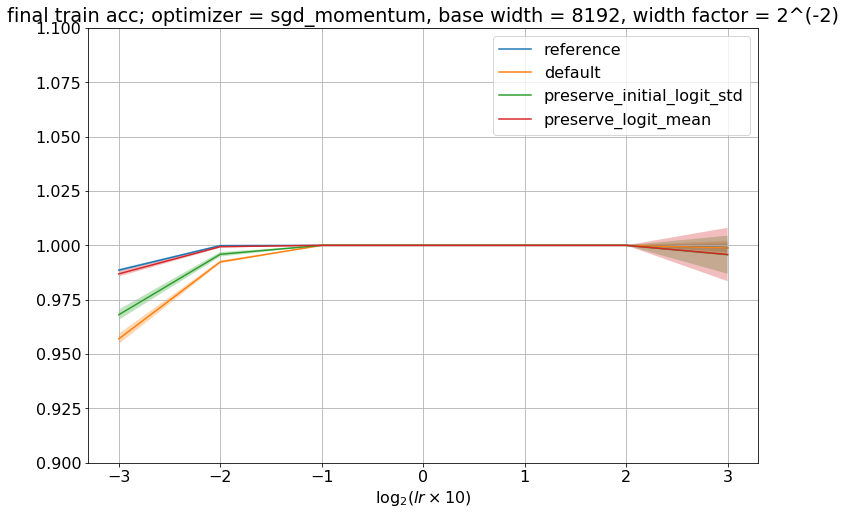

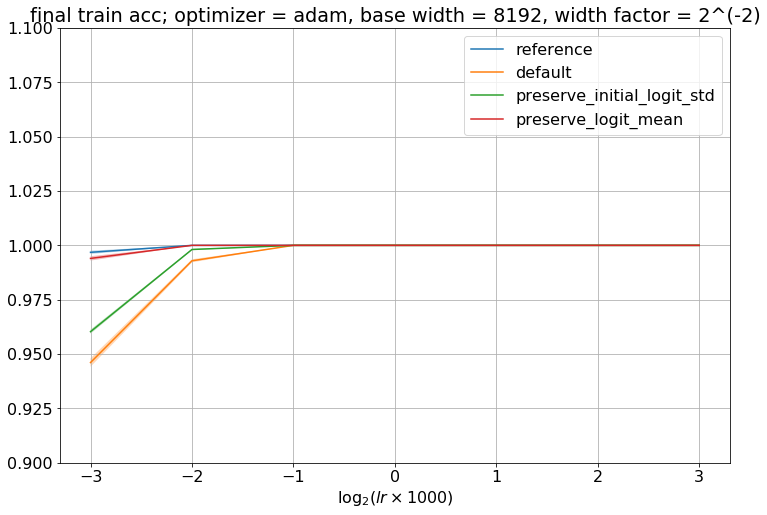

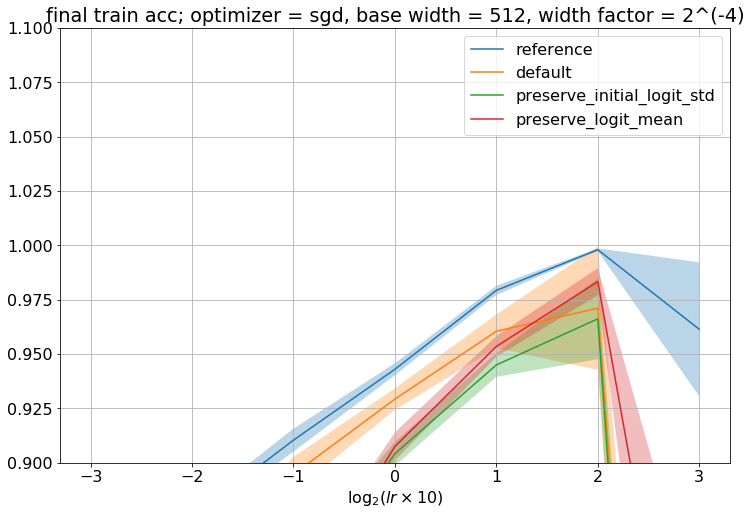

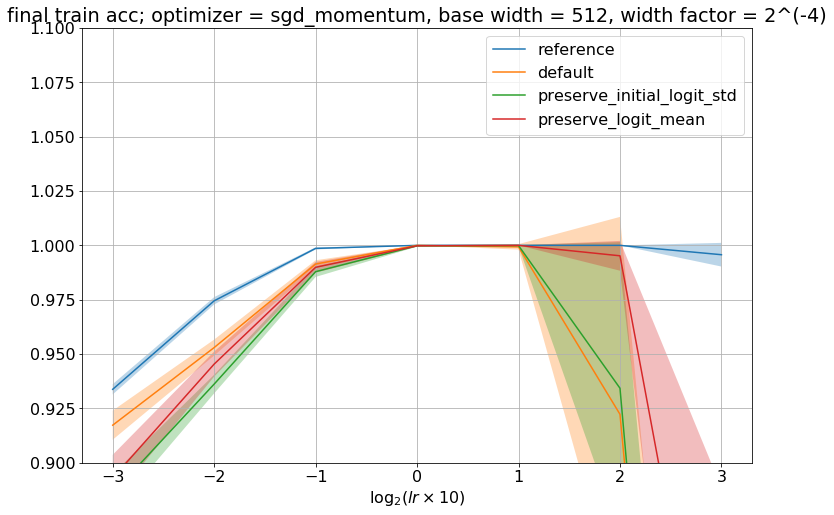

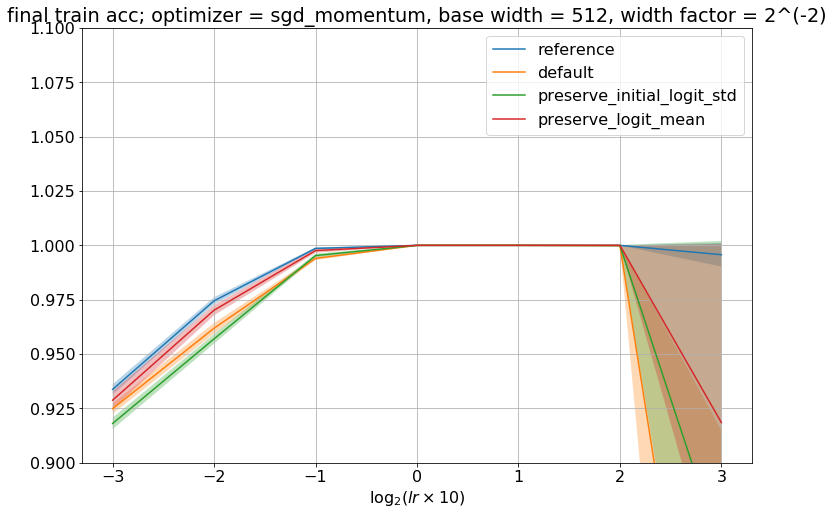

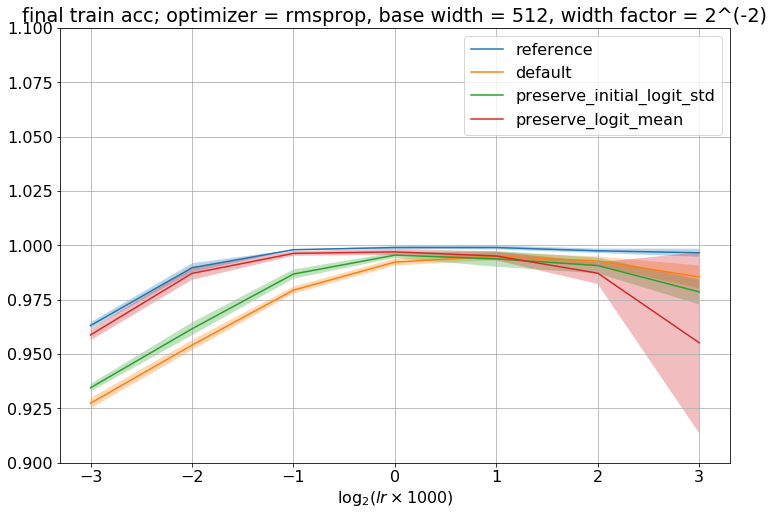

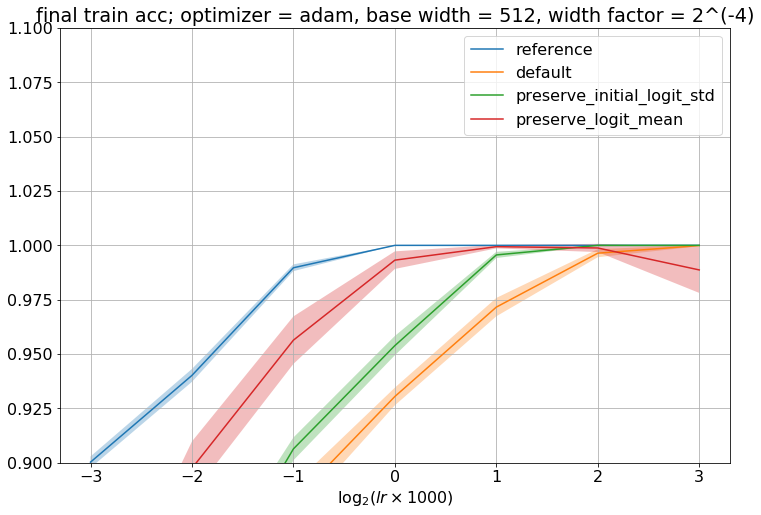

In [338]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            data = [[
                final_train_accs[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed]
                for log_lr_factor in log_lr_factors
            ] for seed in range(num_seeds)]
            data = np.array(data)
            data_mean = data.mean(axis=0)
            data_std = data.std(axis=0)
            plt.plot(log_lr_factors, data_mean)
            plt.fill_between(
                log_lr_factors,
                data_mean - data_std, data_mean + data_std,
                alpha=0.3
            )

            for scaling_mode in scaling_modes:
                data = [[
                    final_train_accs[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(log_lr_factors, data_mean)
                plt.fill_between(
                    log_lr_factors,
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

            if show_adapted_results:
                for adaptivity_mode in adaptivity_modes[1:]:
                    data = [[
                        final_train_accs[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(log_lr_factors, data_mean)
                    plt.fill_between(
                        log_lr_factors,
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

            plt.title('final train acc; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
            plt.legend(legend_list)
            plt.ylim((0.9,1.1))
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = 1e-1
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = 1e-3
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()

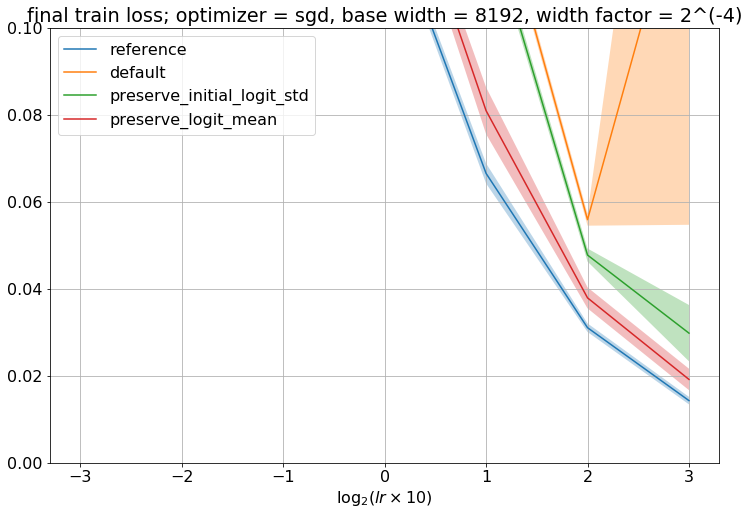

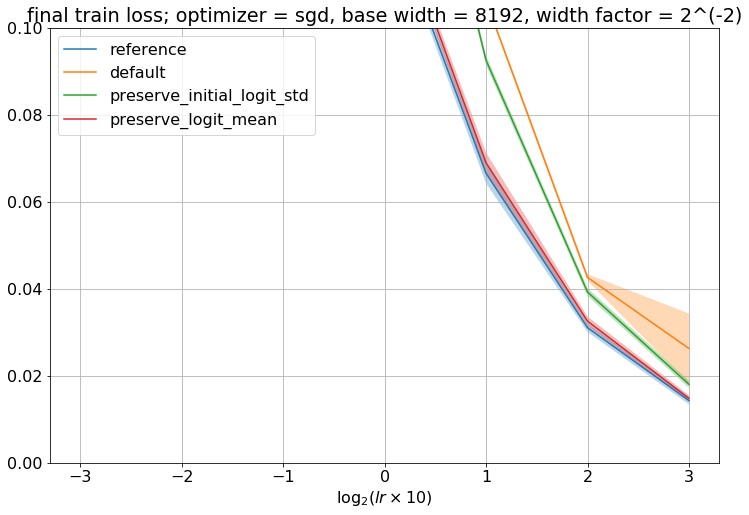

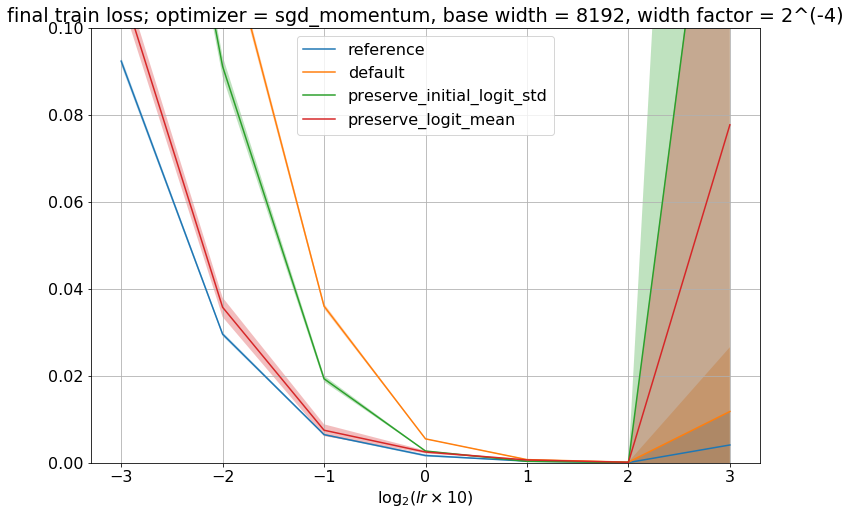

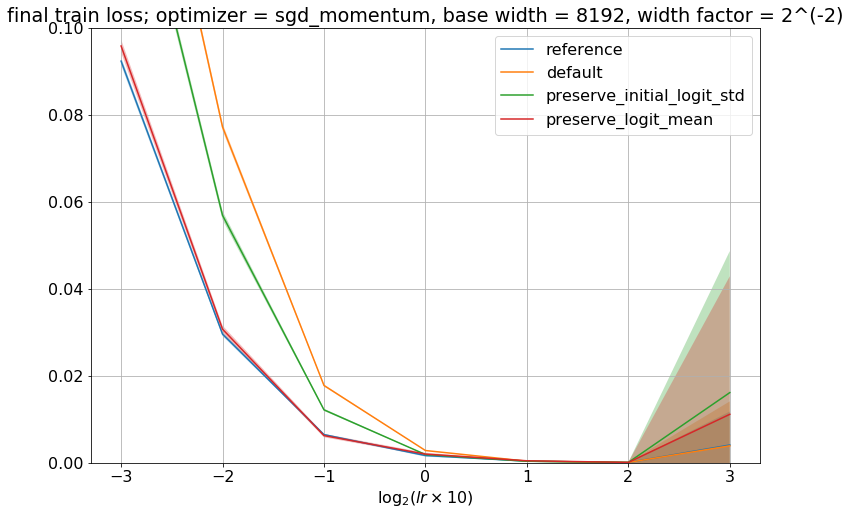

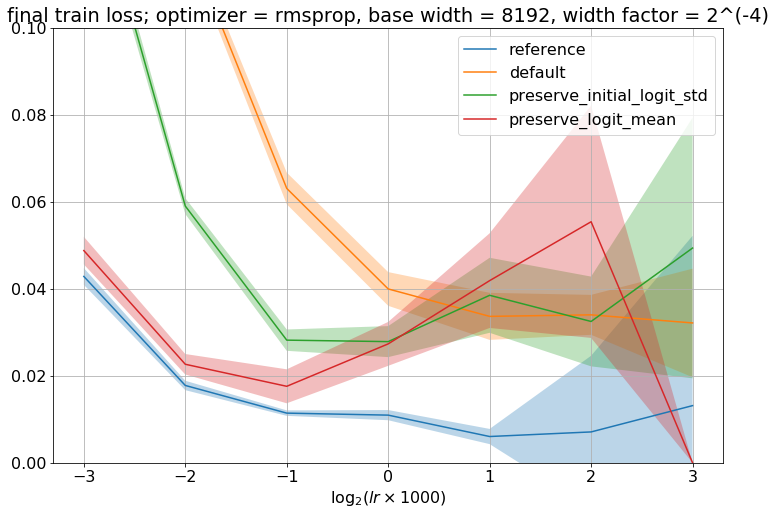

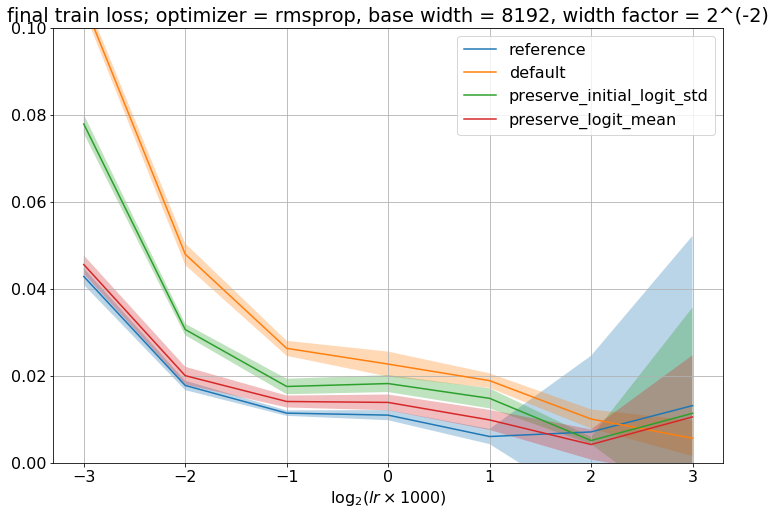

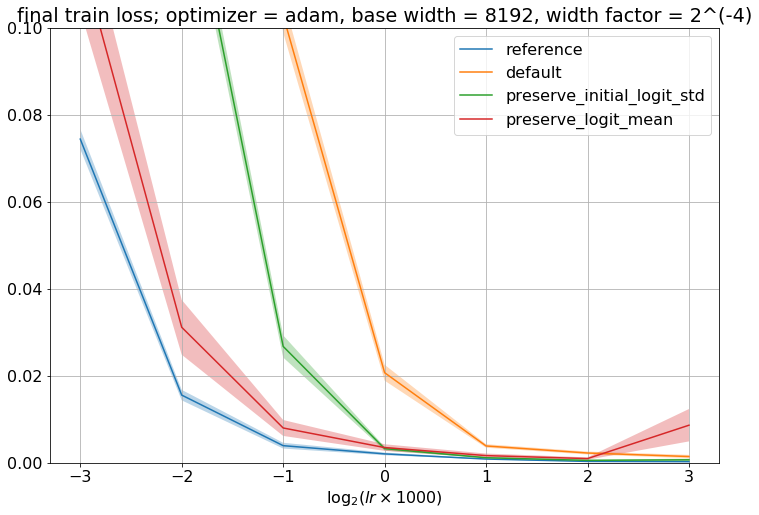

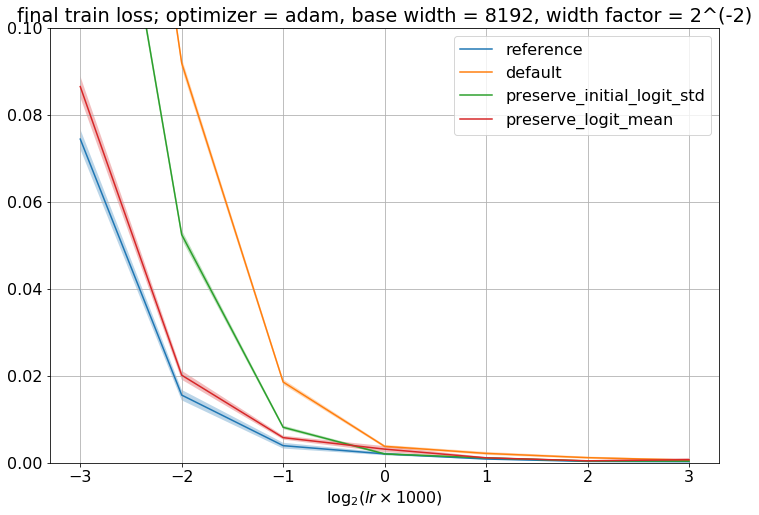

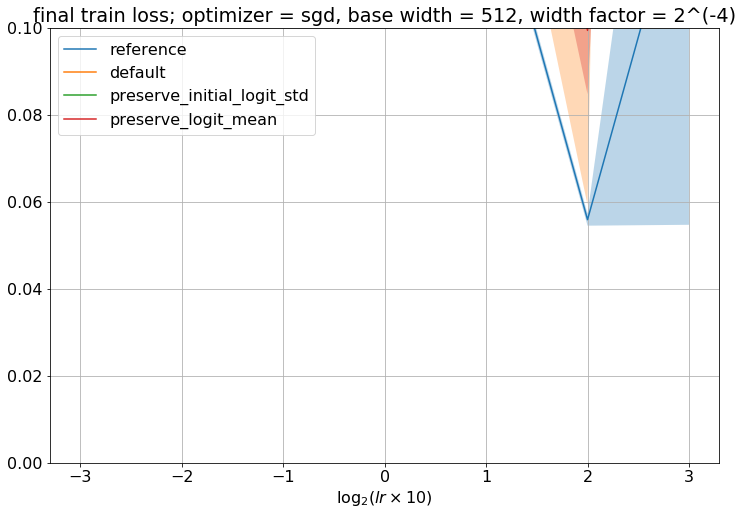

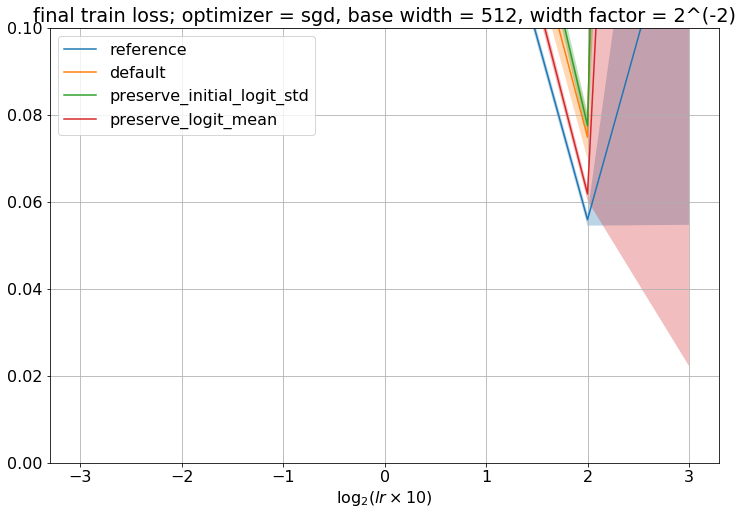

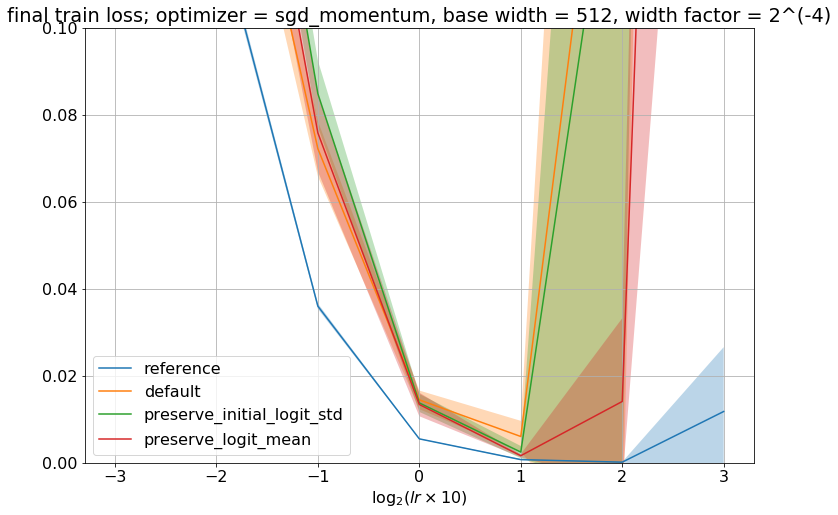

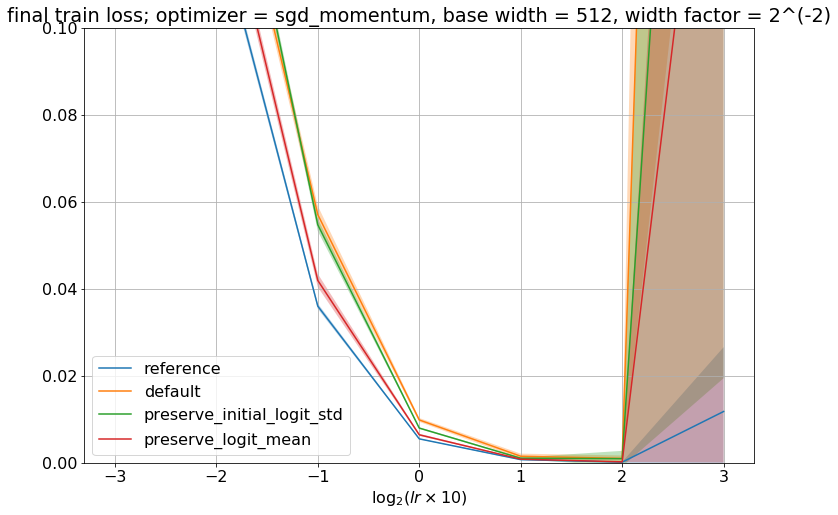

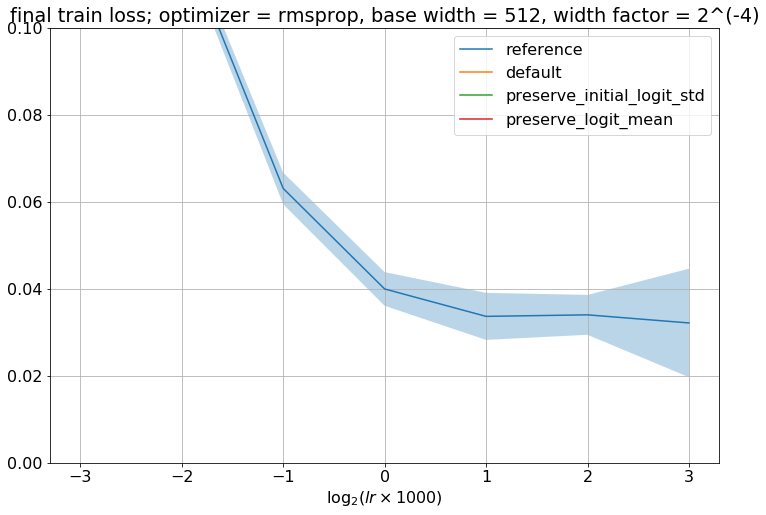

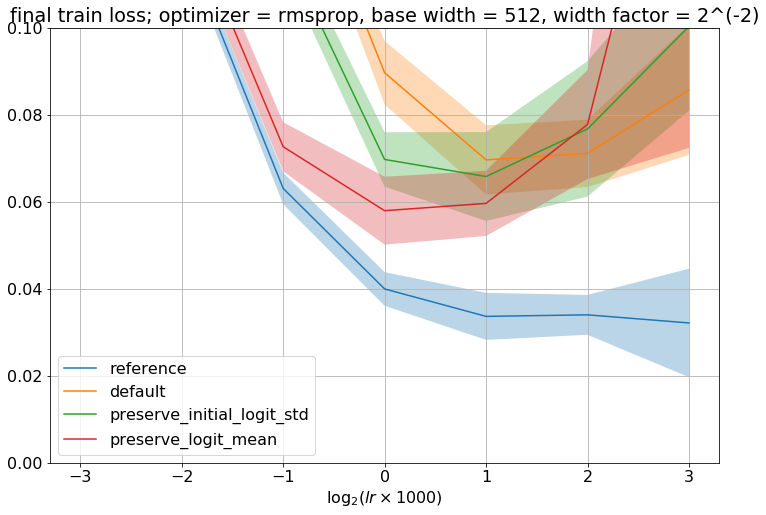

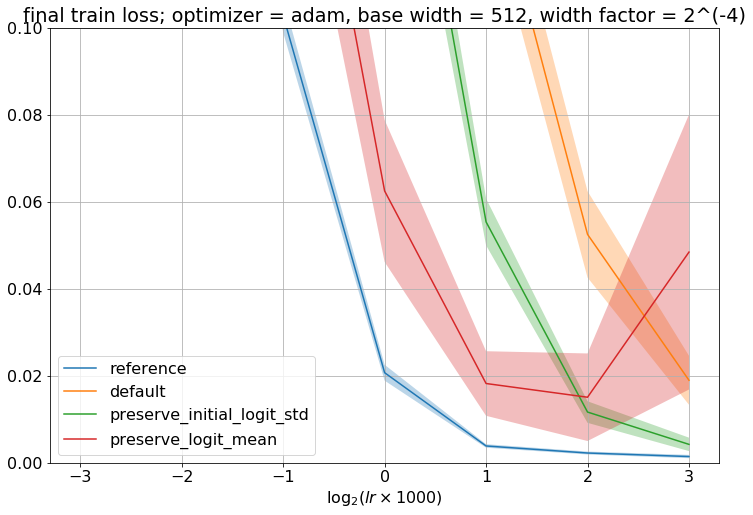

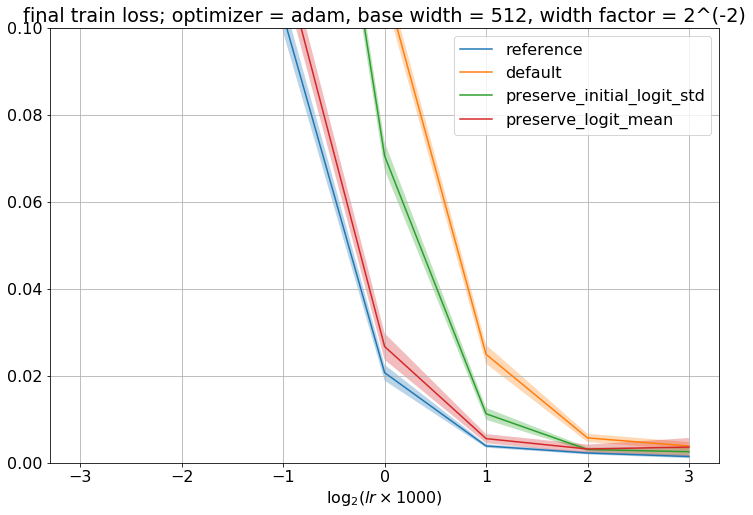

In [339]:
for base_width in base_widths:
    for optimization_mode in optimization_modes:
        for log_width_factor in log_width_factors[:-1]:
            _ = plt.figure(figsize=(12,8))

            data = [[
                final_train_losses[base_width][optimization_mode]['none']['default'][0][log_lr_factor][seed]
                for log_lr_factor in log_lr_factors
            ] for seed in range(num_seeds)]
            data = np.array(data)
            data_mean = data.mean(axis=0)
            data_std = data.std(axis=0)
            plt.plot(log_lr_factors, data_mean)
            plt.fill_between(
                log_lr_factors,
                data_mean - data_std, data_mean + data_std,
                alpha=0.3
            )

            for scaling_mode in scaling_modes:
                data = [[
                    final_train_losses[base_width][optimization_mode]['none'][scaling_mode][log_width_factor][log_lr_factor][seed]
                    for log_lr_factor in log_lr_factors
                ] for seed in range(num_seeds)]
                data = np.array(data)
                data_mean = data.mean(axis=0)
                data_std = data.std(axis=0)
                plt.plot(log_lr_factors, data_mean)
                plt.fill_between(
                    log_lr_factors,
                    data_mean - data_std, data_mean + data_std,
                    alpha=0.3
                )

            if show_adapted_results:
                for adaptivity_mode in adaptivity_modes[1:]:
                    data = [[
                        final_train_losses[base_width][optimization_mode][adaptivity_mode]['preserve_initial_logit_std'][log_width_factor][log_lr_factor][seed]
                        for log_lr_factor in log_lr_factors
                    ] for seed in range(num_seeds)]
                    data = np.array(data)
                    data_mean = data.mean(axis=0)
                    data_std = data.std(axis=0)
                    plt.plot(log_lr_factors, data_mean)
                    plt.fill_between(
                        log_lr_factors,
                        data_mean - data_std, data_mean + data_std,
                        alpha=0.3
                    )

            plt.title('final train loss; optimizer = {}, base width = {}, width factor = 2^({})'.format(optimization_mode, base_width, log_width_factor))
            plt.legend(legend_list)
            plt.ylim((0.,0.1))
            if optimization_mode in ['sgd', 'sgd_momentum']:
                base_lr = 1e-1
            elif optimization_mode in ['rmsprop', 'adam']:
                base_lr = 1e-3
            plt.xlabel(r'$\log_2 (lr \times {:.0f})$'.format(1/base_lr))
            plt.grid(True)
            plt.show()